# Model Laptop Price Prediction

- Xem xét và thực hiện các phương pháp đánh giá lựa chọn các features cần thiết để đưa vào mô hình

- Sử dụng mô hình phù hợp để đạt hiệu suất tốt nhất có thể

- Giả thiết phần tiền xử lý đã xử lý hoàn chỉnh các missing và outlier có ý nghĩa được giữ lại, để từ đây tách ra 2 hướng dùng các mô hình Tree-Based để tránh ảnh hưởng bởi outlier hợp lệ tồn đọng và tách riêng thành 2 bộ dataset mới

## Thư viện và đọc dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, skew, kurtosis, f_oneway
import ast
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib

In [2]:
df = pd.read_csv('laptop_train.csv')
df

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,...,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
0,0,227.00,https://www.thegioididong.com/laptop/asus-fa40...,vỏ nhựa - nắp lưng kim loại,2048.0,1024.0,2560.0,5.3,311.0,asus,...,8.0,full hd,14.0,amd,0,1,0,1,1,0
1,0,235.00,https://www.thegioididong.com/laptop/lenovo-id...,vỏ nhựa,1024.0,1024.0,1920.0,5.2,359.3,lenovo,...,0.0,hd,15.6,intel,1,0,0,1,1,0
2,0,232.50,https://www.thegioididong.com/laptop/asus-vivo...,vỏ nhựa,512.0,512.0,1920.0,5.3,359.7,asus,...,0.0,hd,15.6,intel,1,0,0,1,1,1
3,0,212.40,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.0,304.1,apple,...,0.0,hd,13.3,apple,1,1,1,0,1,1
4,0,271.09,https://www.thegioididong.com/laptop/acer-nitr...,vỏ nhựa,1024.0,512.0,1920.0,5.1,360.4,acer,...,4.0,hd,15.6,intel,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,0,250.30,https://cellphones.com.vnlaptop-msi-cyborg-15-...,vỏ nhựa - nắp lưng kim loại,512.0,512.0,1920.0,5.3,359.4,msi,...,4.0,hd,15.6,intel,0,0,0,1,1,0
1072,0,199.10,https://cellphones.com.vn/laptop-dell-xps-13-9...,vỏ kim loại,1024.0,1024.0,2560.0,5.4,295.3,dell,...,0.0,full hd,13.4,intel,1,0,1,0,0,0
1073,0,221.00,https://cellphones.com.vnlaptop-lenovo-yoga-sl...,vỏ kim loại,1024.0,1024.0,1920.0,5.3,312.0,lenovo,...,0.0,full hd,14.0,intel,1,0,1,0,0,0
1074,0,219.30,https://cellphones.com.vnlaptop-lenovo-yoga-sl...,vỏ kim loại,1024.0,1024.0,2880.0,5.4,312.0,lenovo,...,0.0,full hd,14.0,intel,1,0,1,0,0,1


## EDA 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cam_ung                   1076 non-null   int64  
 1   height_mm                 1076 non-null   float64
 2   url_path                  1076 non-null   object 
 3   material                  1076 non-null   object 
 4   storage_max_support       1076 non-null   float64
 5   storage_gb                1076 non-null   float64
 6   display_width             1076 non-null   float64
 7   bluetooth_version         1076 non-null   float64
 8   width_mm                  1076 non-null   float64
 9   manufacturer              1076 non-null   object 
 10  cpu_max_speed             1076 non-null   float64
 11  root_price                1076 non-null   float64
 12  cpu_threads               1076 non-null   float64
 13  cpu_cores                 1076 non-null   float64
 14  ram_spee

Xóa các cột không dùng 

In [4]:
drop_cols = ['url_path', 'name', 'nhu_cau_su_dung', 'image', 'product_id', 'discounted_price']
df.drop(columns=drop_cols, axis=1, inplace=True)

Chuyển đổi các cột discrete sang int64

In [5]:
all_cols = df.select_dtypes(include='float64').columns.to_list()
keep_float = ['product_weight', 'battery_capacity', 'display_size',
              'bluetooth_version', 'width_mm', 'height_mm', 'depth_mm', 
              'cpu_speed', 'cpu_max_speed', 'vga_vram']
convert_to_int = [col for col in all_cols if col not in keep_float]
for col in convert_to_int:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('int64')

Xác định các cột có kiểu category để thực hiện chuyển đổi kiểu dữ liệu

In [6]:
result = []
len_df = len(df)
for col in df.columns:
    vc = len(df[col].value_counts(dropna=False))
    result.append({'feature': col, 'count': vc, 'percent': round((vc/len_df)*100, 4)})

count_table = pd.DataFrame(result)
count_table

,feature,count,percent
0,cam_ung,2,0.1859
1,height_mm,173,16.0781
2,material,3,0.2788
3,storage_max_support,11,1.0223
4,storage_gb,10,0.9294
5,display_width,13,1.2082
6,bluetooth_version,7,0.6506
7,width_mm,135,12.5465
8,manufacturer,13,1.2082
9,cpu_max_speed,64,5.9480


In [7]:
cat_table = count_table[count_table['percent'] <= 5]
print(cat_table)

cat_cols = cat_table[cat_table['count'] <= 10]['feature'].tolist()
print(cat_cols)

nearly_cat_cols = [col for col in cat_table['feature'].tolist() if col not in cat_cols]
print(nearly_cat_cols)

                     feature  count  percent
0                    cam_ung      2   0.1859
2                   material      3   0.2788
3        storage_max_support     11   1.0223
4                 storage_gb     10   0.9294
5              display_width     13   1.2082
6          bluetooth_version      7   0.6506
8               manufacturer     13   1.2082
11               cpu_threads     20   1.8587
12                 cpu_cores     16   1.4870
13                 ram_speed     23   2.1375
15                  ram_type      7   0.6506
16              refresh_rate      8   0.7435
18               ram_storage     13   1.2082
19            is_installment      2   0.1859
20                 ram_slots      5   0.4647
21                os_version      5   0.4647
23              laptop_color     11   1.0223
25                  vga_type      2   0.1859
27                 vga_brand      5   0.4647
28                cpu_series     36   3.3457
29            display_height     18   1.6729
30        

danh sách các cột kiểu category theo thống kê số lượng giá trị phân loại và ý nghĩa của các cột

['cam_ung', 'material', 'storage_gb', 'bluetooth_version', 'ram_type', 
                    'refresh_rate', 'is_installment', 'ram_slots', 'os_version', 'vga_type', 
                    'vga_brand', 'vga_vram', 'laptop_camera', 'cpu_brand', 'hoc_tap_van_phong', 
                    'laptop_sang_tao_noi_dung', 'mong_nhe', 'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong']

In [8]:
# thực hiện chuyển đổi kiểu dữ liệu
# categorical_cols = ['cam_ung', 'material', 'storage_max_support', 'storage_gb', 
#                     'display_width', 'bluetooth_version', 'manufacturer', 'cpu_threads', 
#                     'cpu_cores', 'ram_speed', 'ram_type', 'refresh_rate', 'ram_storage', 
#                     'is_installment', 'ram_slots', 'os_version', 'laptop_color', 'vga_type', 
#                     'vga_brand', 'cpu_series', 'display_height', 'vga_vram', 'laptop_camera', 
#                     'display_size', 'cpu_brand', 'hoc_tap_van_phong', 'laptop_sang_tao_noi_dung',
#                     'mong_nhe', 'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong']

categorical_cols = ['cam_ung', 'material', 'storage_gb', 'bluetooth_version', 'ram_type', 
                    'refresh_rate', 'is_installment', 'ram_slots', 'os_version', 'vga_type', 
                    'vga_brand', 'vga_vram', 'laptop_camera', 'cpu_brand', 'hoc_tap_van_phong', 
                    'laptop_sang_tao_noi_dung', 'mong_nhe', 'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong']

for col in categorical_cols:
    df[col] = df[col].astype('category')
    
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()    
print(numerical_cols)

object_cols = df.select_dtypes(include='object').columns.tolist()
print(object_cols)

['height_mm', 'storage_max_support', 'display_width', 'width_mm', 'cpu_max_speed', 'root_price', 'cpu_threads', 'cpu_cores', 'ram_speed', 'product_weight', 'cpu_speed', 'ram_storage', 'battery_capacity', 'depth_mm', 'display_height', 'display_size']
['manufacturer', 'laptop_color', 'cpu_model', 'cpu_series']


In [9]:
for col in object_cols:
    print(f"Value of '{col}':")
    print(df[col].value_counts())
    print('=='*10)

Value of 'manufacturer':
manufacturer
apple       385
asus        184
lenovo      130
hp           90
dell         88
msi          85
acer         82
lg           14
gigabyte     12
samsung       2
huawei        2
masstel       1
vaio          1
Name: count, dtype: int64
Value of 'laptop_color':
laptop_color
đen           305
bạc           271
xám           270
xanh dương    118
vàng           75
hồng            9
xanh lá         8
trắng           7
tím             6
cam             5
be              2
Name: count, dtype: int64
Value of 'cpu_model':
cpu_model
m4        152
m3         80
m4 pro     50
1235u      45
13620h     43
         ... 
5600h       1
1195g7      1
4600h       1
5800h       1
340         1
Name: count, Length: 112, dtype: int64
Value of 'cpu_series':
cpu_series
core i5               228
m4                    172
core i7               129
m3                     84
core ultra 7           69
core ultra 5           50
ryzen 7                46
ryzen 5                42

In [10]:
for col in categorical_cols:
    print(f"Value of '{col}':")
    print(df[col].value_counts())
    print('=='*10)

Value of 'cam_ung':
cam_ung
0    1036
1      40
Name: count, dtype: int64
Value of 'material':
material
vỏ kim loại                    608
vỏ nhựa                        376
vỏ nhựa - nắp lưng kim loại     92
Name: count, dtype: int64
Value of 'storage_gb':
storage_gb
512     702
1024    216
256     130
2048     14
4096      4
8192      3
128       2
32        2
6144      2
3072      1
Name: count, dtype: int64
Value of 'bluetooth_version':
bluetooth_version
5.3    589
5.2    159
0.0     99
5.1     78
5.4     77
5.0     73
4.2      1
Name: count, dtype: int64
Value of 'ram_type':
ram_type
lpddr5     333
ddr4       261
ddr5       249
lpddr5x    217
lpddr4       8
lpddr4x      7
gddr5        1
Name: count, dtype: int64
Value of 'refresh_rate':
refresh_rate
60     588
120    241
144    171
165     36
240     27
90      10
180      2
250      1
Name: count, dtype: int64
Value of 'is_installment':
is_installment
0    656
1    420
Name: count, dtype: int64
Value of 'ram_slots':
ram_slots
0  

thực hiện gom nhóm các giá trị phân loại có tần suất xuất hiện thấp thành 1 nhóm để tăng ý nghĩa thống kê

giữ lại biến 'manufacturer' và 'laptop_color' vì vẫn còn tính chất phân nhóm thống kê

In [11]:
# chuyển đổi sang dạng category
for col in ['laptop_color', 'manufacturer']:
    df[col] = df[col].astype('category')
    
cat_string = ['material', 'manufacturer', 'ram_type', 'os_version', 'laptop_color', 
              'vga_type', 'vga_brand', 'cpu_series', 'cpu_brand', 'laptop_camera']

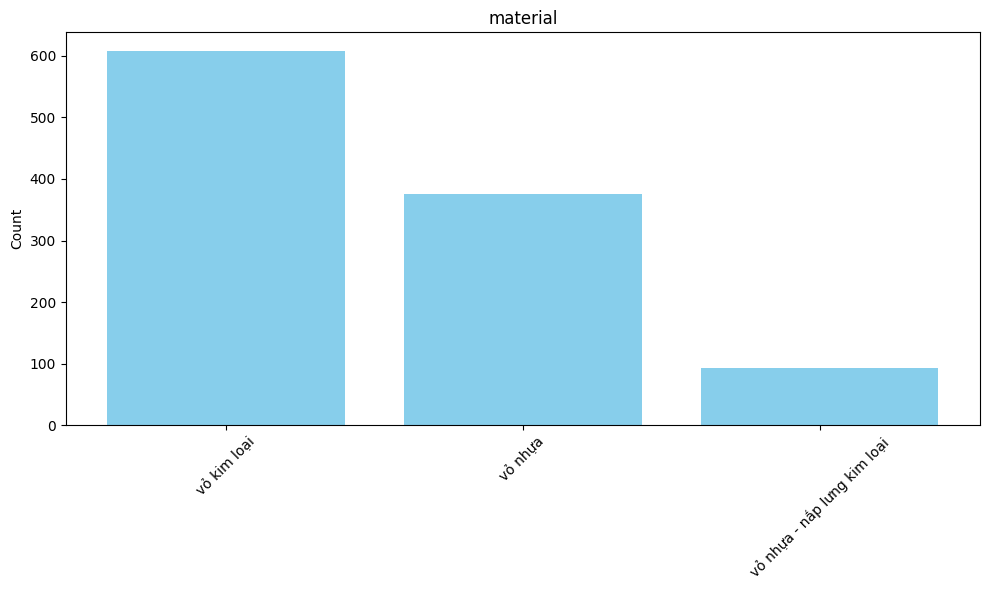

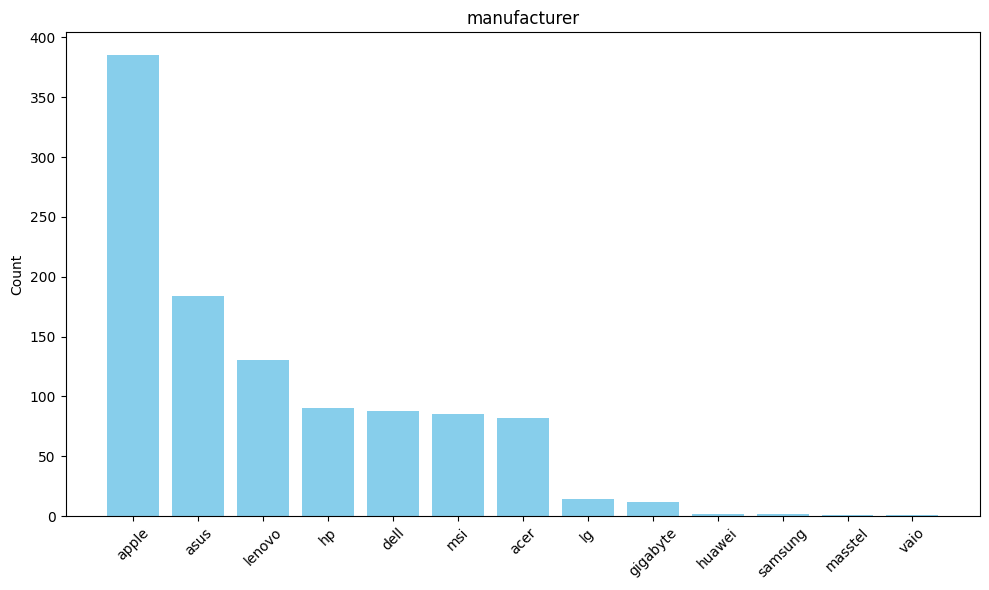

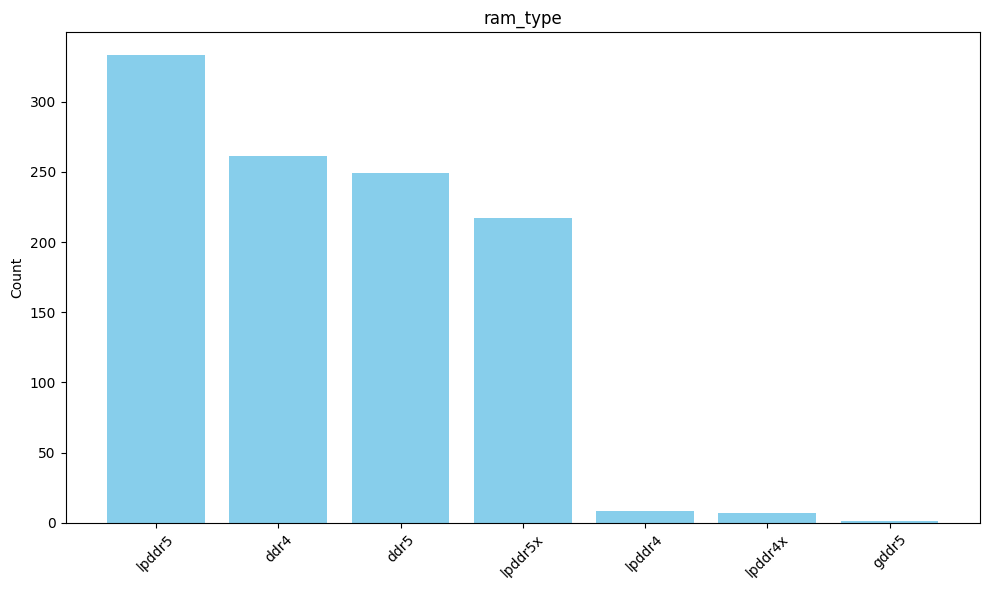

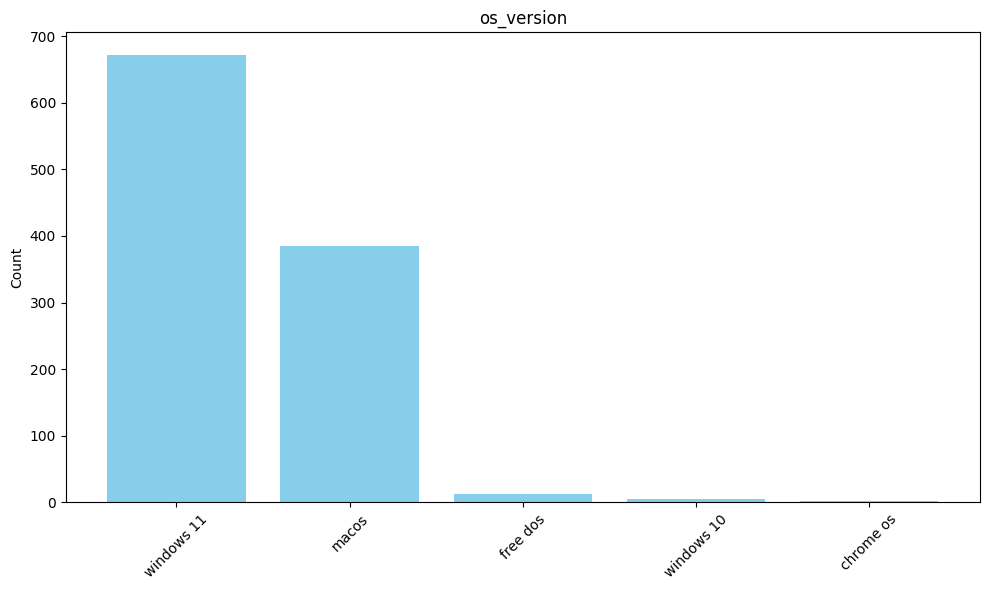

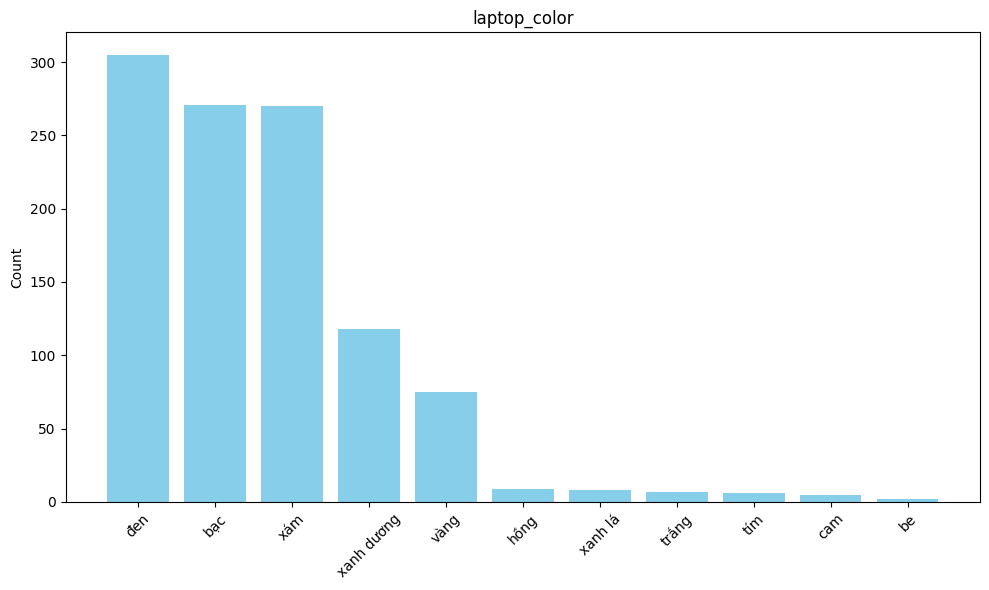

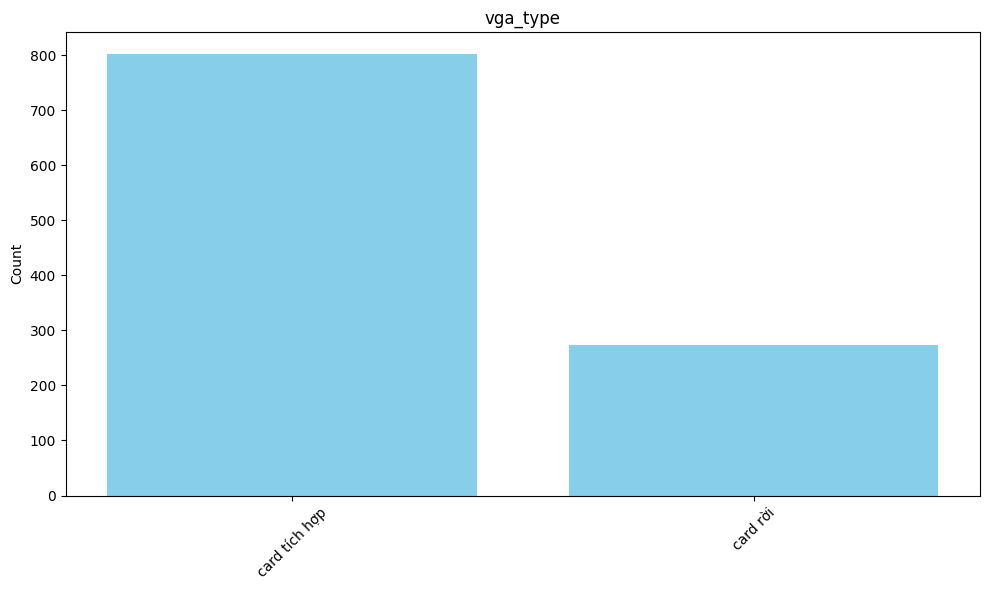

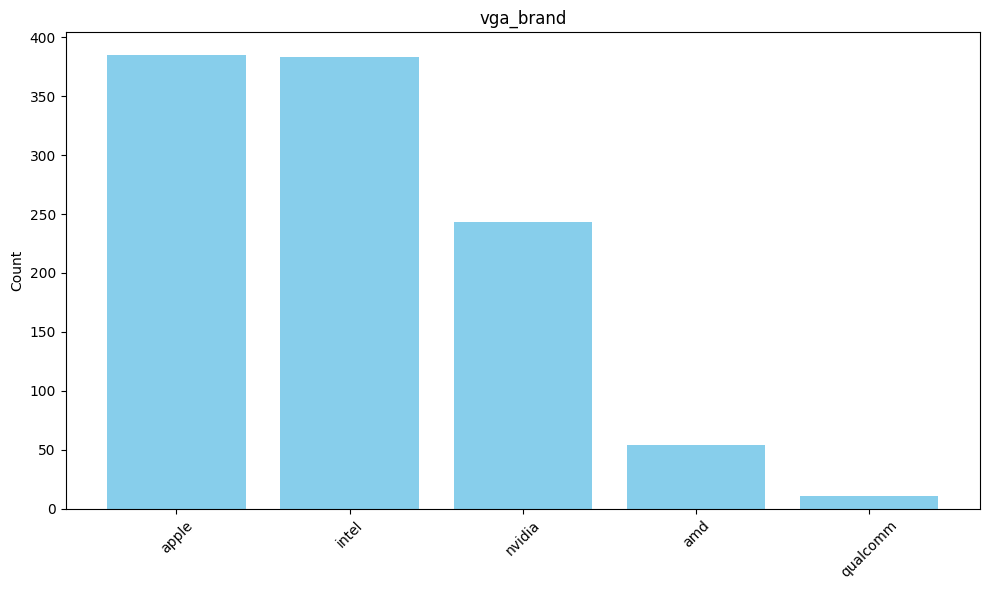

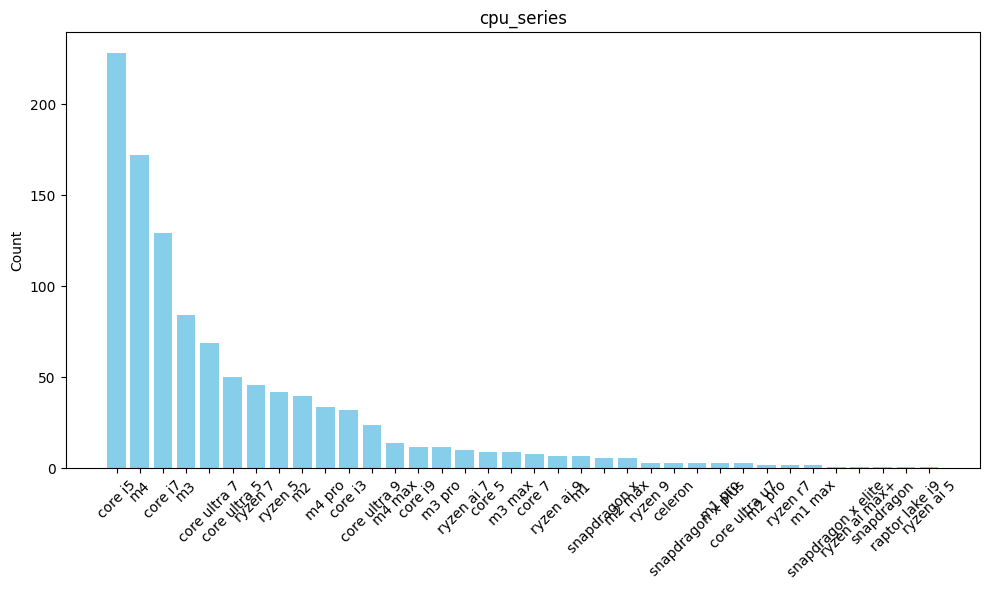

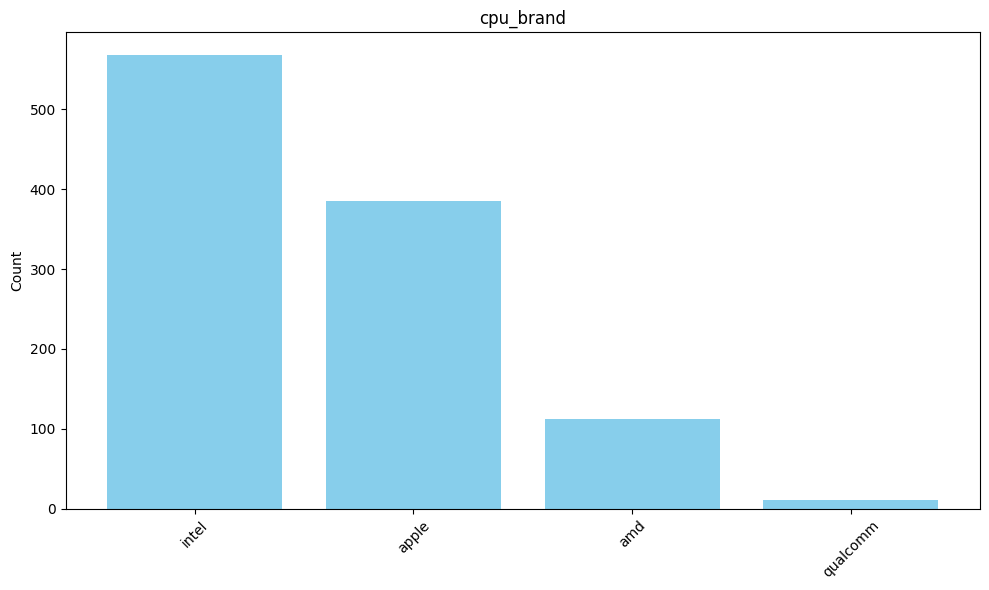

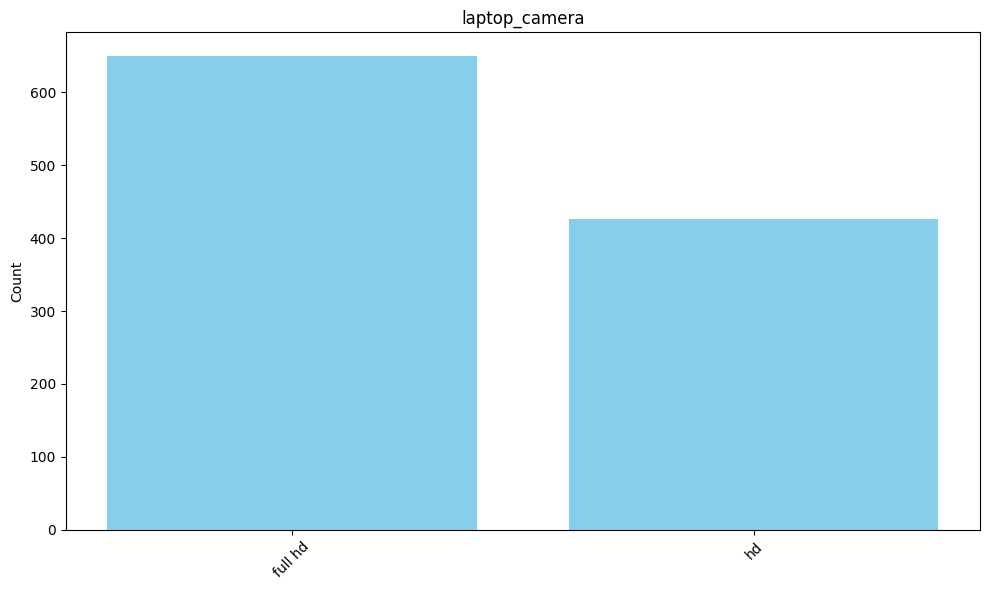

In [12]:
# def plot_bar_charts(df, columns):
#     n = len(columns)
#     rows = math.ceil(n / 3)

#     fig, axes = plt.subplots(rows, 3, figsize=(6 * 3, 5 * rows))

#     # Flatten axes nếu nhiều dòng, để dễ indexing
#     axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

#     for i, col in enumerate(columns):
#         counts = df[col].value_counts().head(10)  # lấy top 10 giá trị
#         axes[i].bar(counts.index.astype(str), counts.values, color='skyblue')
#         axes[i].set_title(f'{col}')
#         axes[i].tick_params(axis='x', rotation=45)
#         axes[i].set_ylabel('Count')

#     # Ẩn các subplot dư thừa nếu không đủ cột để lấp đầy
#     for j in range(i + 1, len(axes)):
#         axes[j].set_visible(False)

#     plt.tight_layout()
#     plt.show()

def plot_bar_charts(df, columns):
    for col in columns:
        counts = df[col].value_counts()

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(counts.index.astype(str), counts.values, color='skyblue')
        ax.set_title(f'{col}')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('Count')
        plt.tight_layout()
        plt.show()  # Hiển thị từng ảnh riêng

    
plot_bar_charts(df, cat_string)

In [13]:
def cat_col_list(st, rare_list, name):
    rare_list = rare_list 
    return f'other_{name}' if st in rare_list else st

manufacturer_list = ['lg', 'gigabyte', 'huawei', 'huawei', 'samsung', 'masstel', 'vaio']
ram_type_list =['lpddr4', 'lpddr4x', 'gddr5']
os_list = ['free dos', 'windows 10', 'chrome os']
color_list = ['hồng', 'xanh lá', 'trắng', 'tím', 'cam', 'be']
vga_list = ['amd', 'qualcomm']
cpu_list = ['amd', 'qualcomm']

df['manufacturer'] = df['manufacturer'].apply(lambda x: cat_col_list(x, manufacturer_list, 'manufacturer'))
df['ram_type'] = df['ram_type'].apply(lambda x: cat_col_list(x, ram_type_list, 'ram_type'))
df['os_version'] = df['os_version'].apply(lambda x: cat_col_list(x, os_list, 'os_version'))
df['laptop_color'] = df['laptop_color'].apply(lambda x: cat_col_list(x, color_list, 'color'))
df['vga_brand'] = df['vga_brand'].apply(lambda x: cat_col_list(x, vga_list, 'vga_type'))
df['cpu_brand'] = df['cpu_brand'].apply(lambda x: cat_col_list(x, cpu_list, 'brand'))

convert_list = ['manufacturer', 'ram_type', 'os_version', 'laptop_color', 'vga_brand', 'cpu_brand']
for col in convert_list:
    df[col] = df[col].astype('category')

'cpu_model' và 'cpu_series' sẽ không cần thiết dùng cho mô hình vì tỉ lệ giá trị unique quá cao

In [14]:
df.drop(['cpu_model', 'cpu_series'], axis=1, inplace=True)

lựa chọn các features category có ảnh hưởng tới root_price qua kiểm định ANOVA

In [15]:
import pandas as pd
from scipy.stats import f_oneway

results = []

# Tạo DataFrame chứa biến phân loại và root_price
categorical_cols = df.select_dtypes(include='category').columns.tolist()
df_categorical = df[categorical_cols].copy()
df_categorical['root_price'] = df['root_price']

# Phân tích ANOVA từng biến
for var in categorical_cols:
    groups = [df_categorical[df_categorical[var] == level]['root_price'].dropna()
              for level in df_categorical[var].dropna().unique()]
    
    if len(groups) > 1:  # tránh lỗi khi chỉ có 1 nhóm
        f_statistic, p_value = f_oneway(*groups)
        impact = "impact" if p_value < 0.05 else "not impact"
        results.append({
            "feature": var,
            "f-statistic": round(f_statistic, 4),
            "p-value": round(p_value, 4),
            "evaluate": impact
        })

# Tạo DataFrame kết quả
anova_df = pd.DataFrame(results)

cat_impact_feats = anova_df[anova_df['evaluate'] == 'impact']['feature'].tolist()
cat_impact_feats

['material',
 'storage_gb',
 'bluetooth_version',
 'manufacturer',
 'ram_type',
 'refresh_rate',
 'is_installment',
 'ram_slots',
 'os_version',
 'laptop_color',
 'vga_brand',
 'vga_vram',
 'laptop_camera',
 'cpu_brand',
 'hoc_tap_van_phong',
 'laptop_sang_tao_noi_dung',
 'mong_nhe',
 'do_hoa_ky_thuat',
 'cao_cap_sang_trong']

xem xét các outlier còn tồn đọng sau khi pre-processing

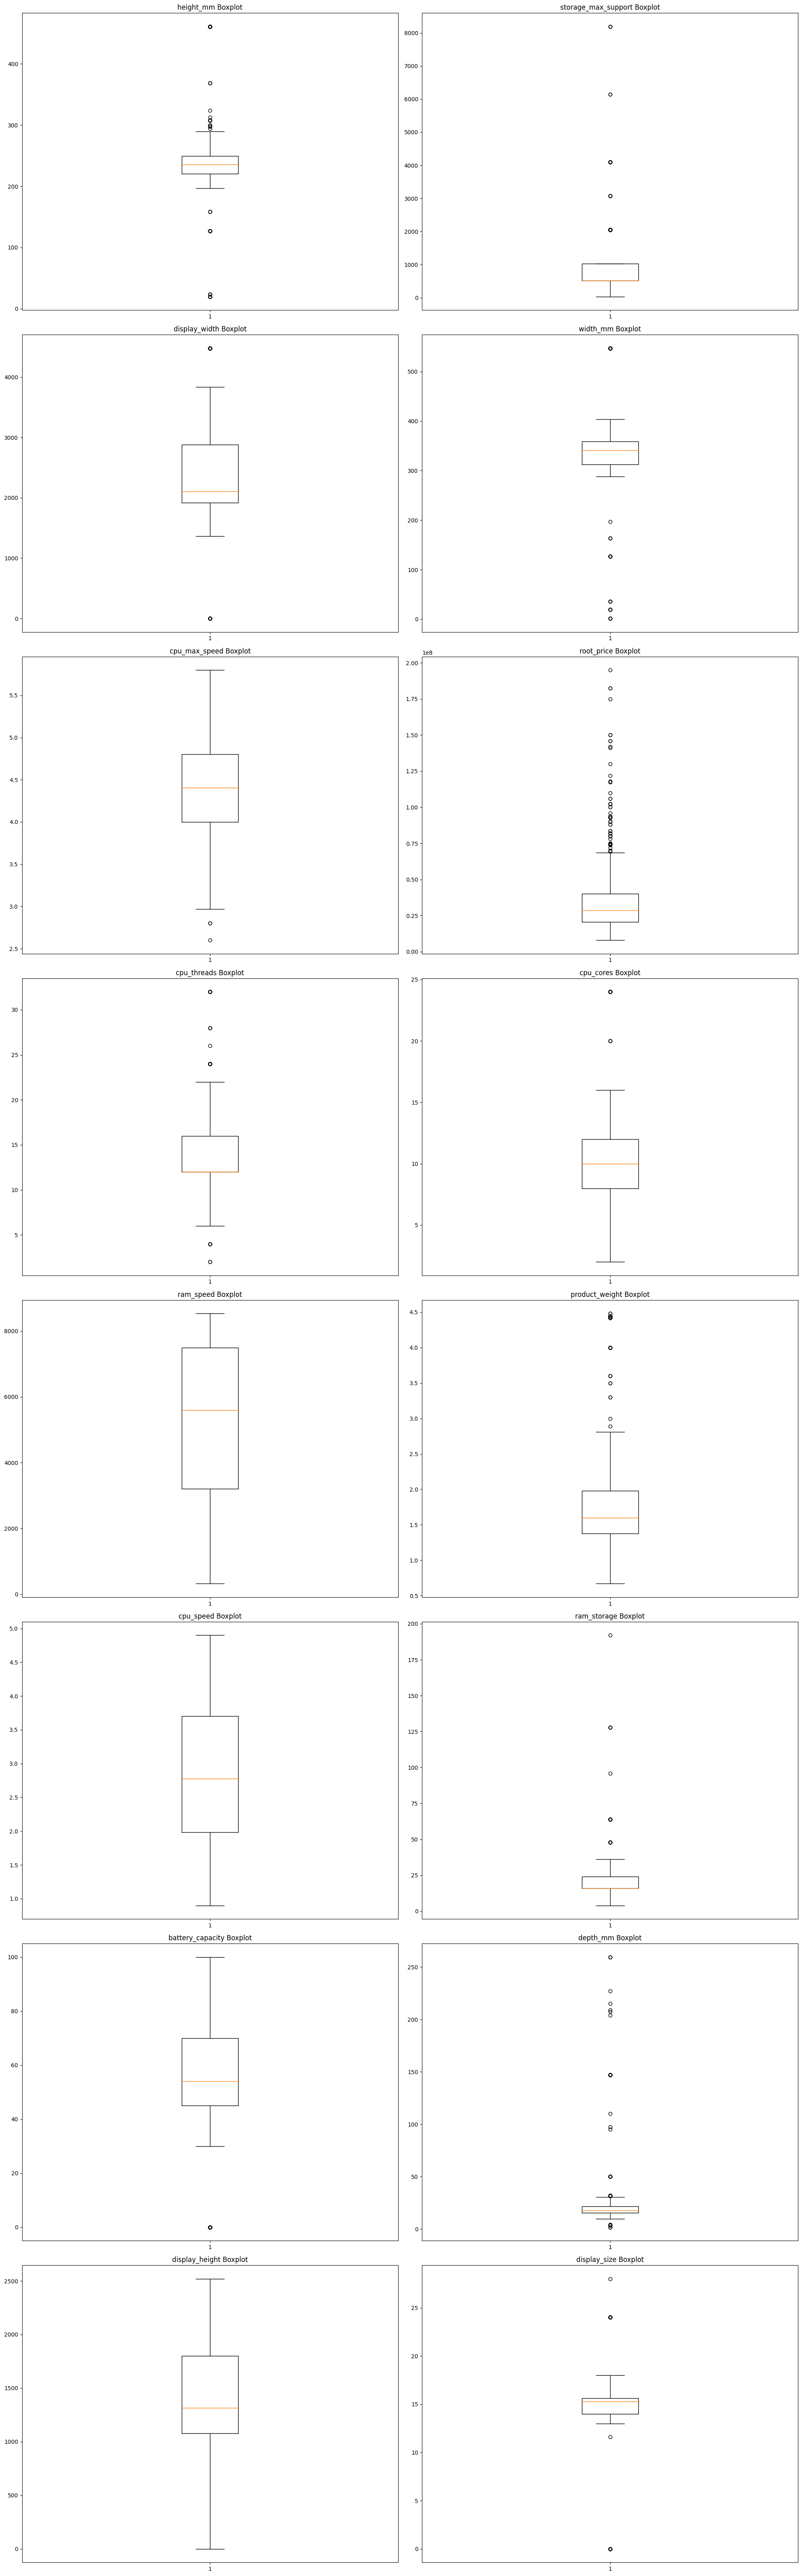

In [16]:
columns_to_plot = numerical_cols
n_cols = 2  # số biểu đồ mỗi hàng
n_rows = math.ceil(len(columns_to_plot) / n_cols)

plt.figure(figsize=(10 * n_cols, 8 * n_rows))  # kích thước tổng thể

for i, col in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.boxplot(col, data=df)
    plt.title(f'{col} Boxplot')
    plt.tight_layout()

plt.show()

hầu hết các cột số đều có outlier và với giả thiết các outlier đều hợp lệ qua khâu xử lý preprocessing

một số cột không bị outlier:
- display_height
- cpu_speed
- ram_speed

height_mm lệch phải 1.9405001564224924
storage_max_support lệch phải 3.691189151588246
display_width lệch phải 0.5053403228395864
width_mm lệch trái -0.569371277272711
cpu_max_speed tương đối gần mức đối xứng -0.18163087676291495
cpu_threads lệch phải 1.4115642254061669
cpu_cores lệch phải 1.5910191047572304
ram_speed tương đối gần mức đối xứng -0.20346277305423394
product_weight lệch phải 2.251264842103528
cpu_speed tương đối gần mức đối xứng -0.08476248842647034
ram_storage lệch phải 5.166309899607274
battery_capacity lệch trái -0.7101377791085423
depth_mm lệch phải 4.54382053394304
display_height tương đối gần mức đối xứng 0.09552423063298833
display_size lệch trái -1.00840848821214

---------- Skew ----------
['height_mm', 'storage_max_support', 'display_width', 'width_mm', 'cpu_threads', 'cpu_cores', 'product_weight', 'ram_storage', 'battery_capacity', 'depth_mm', 'display_size']
---------- Symmetric ----------
['cpu_max_speed', 'ram_speed', 'cpu_speed', 'display_height']


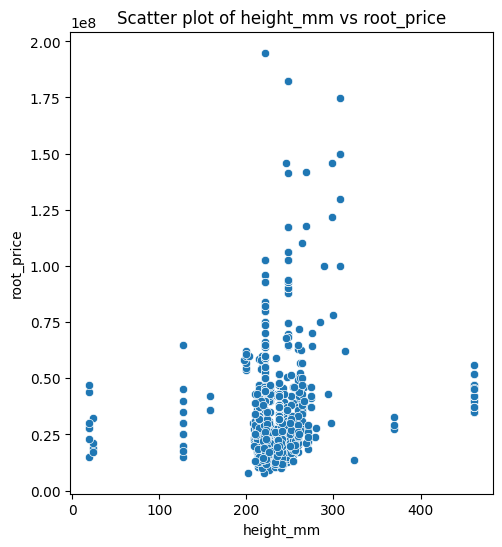

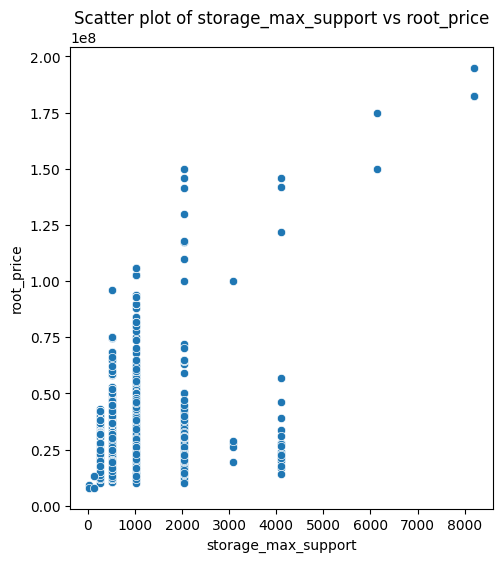

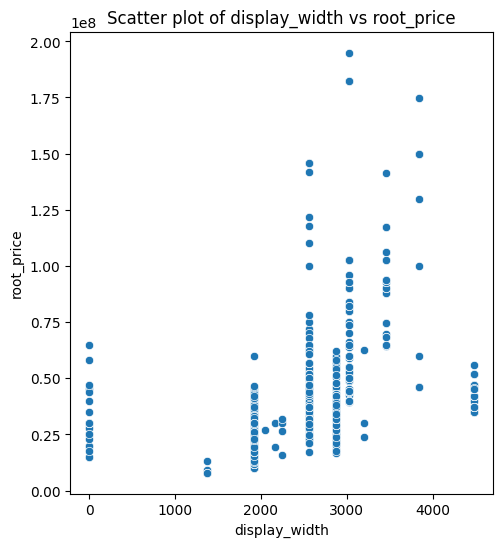

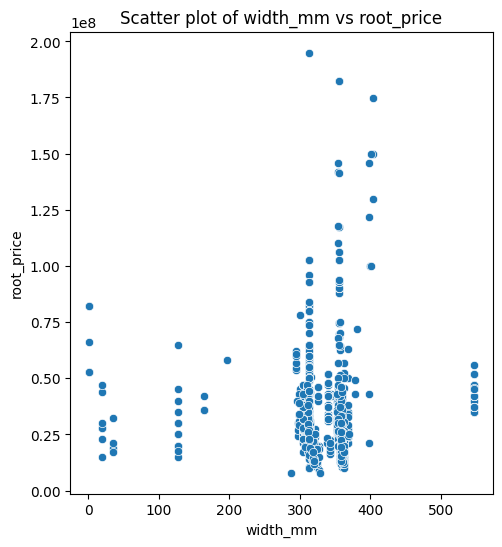

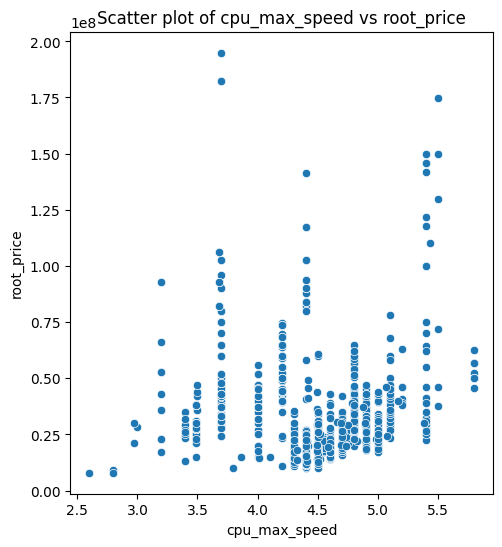

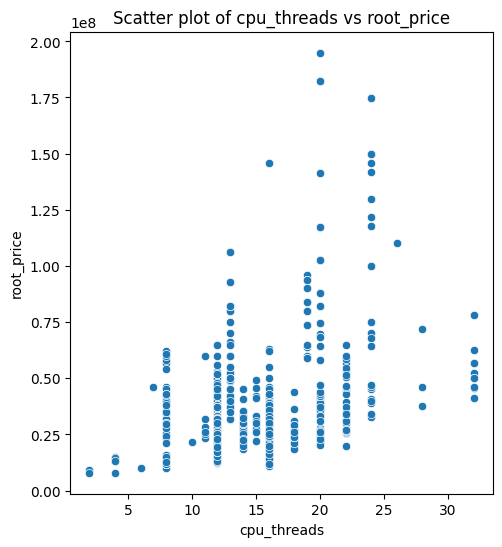

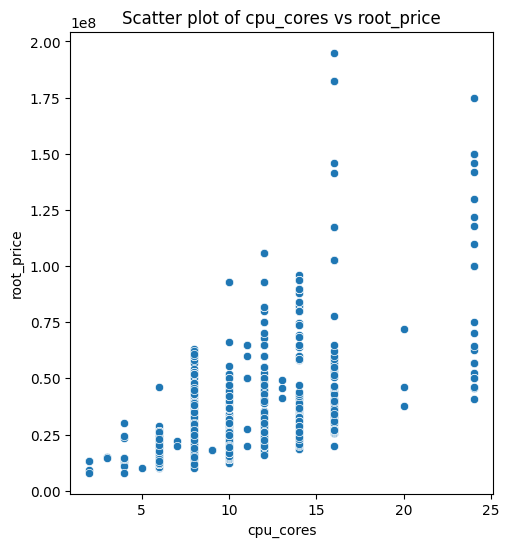

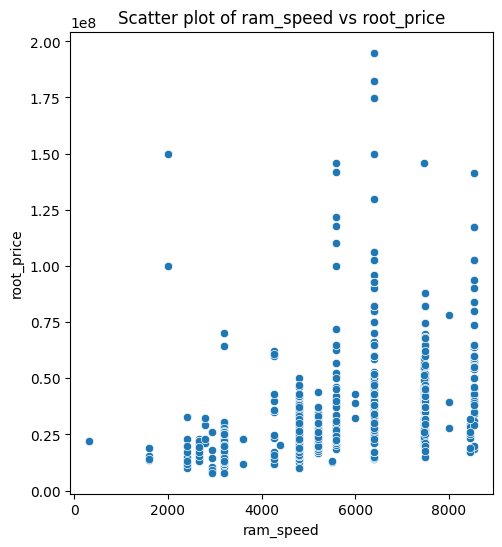

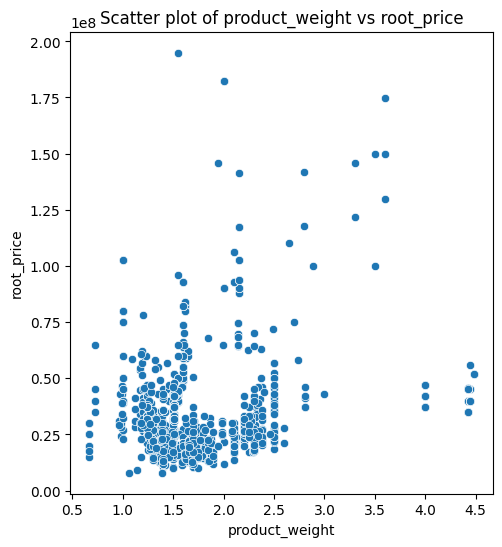

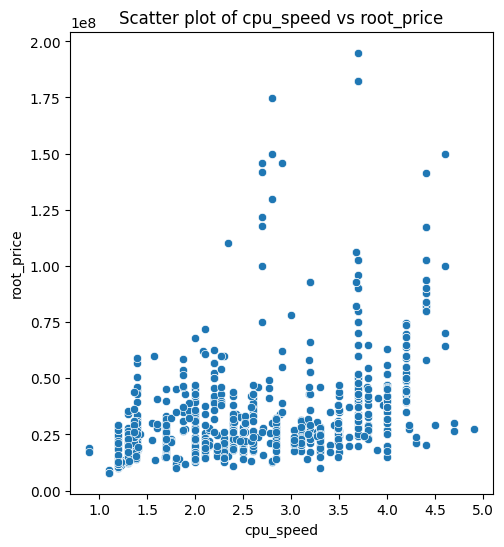

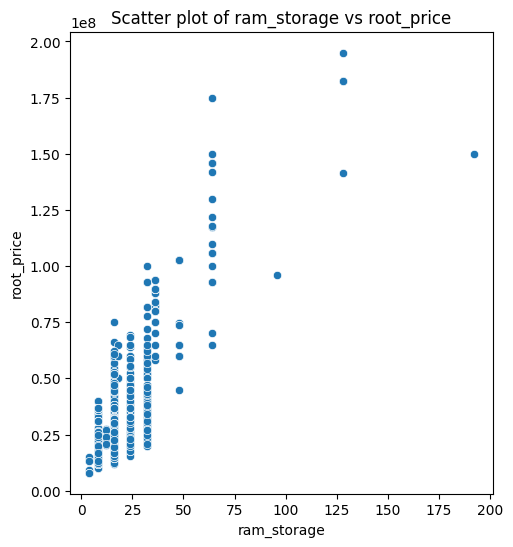

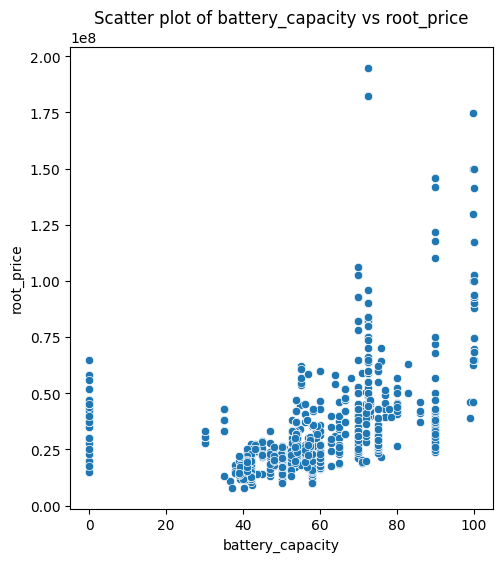

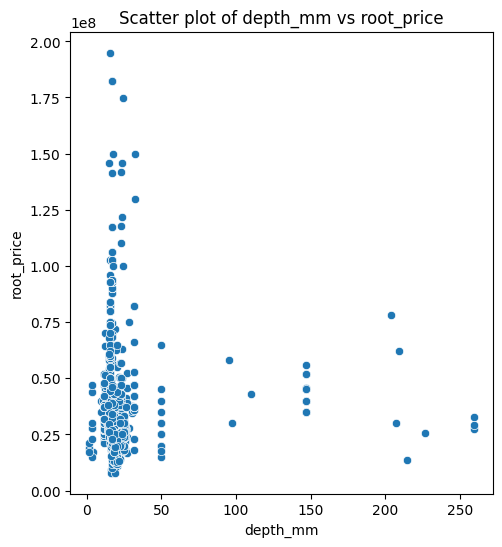

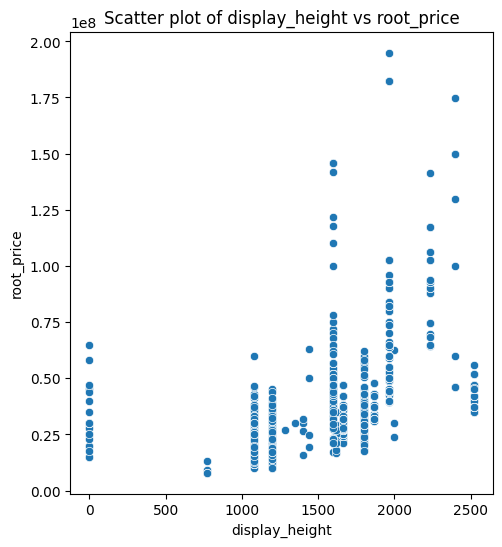

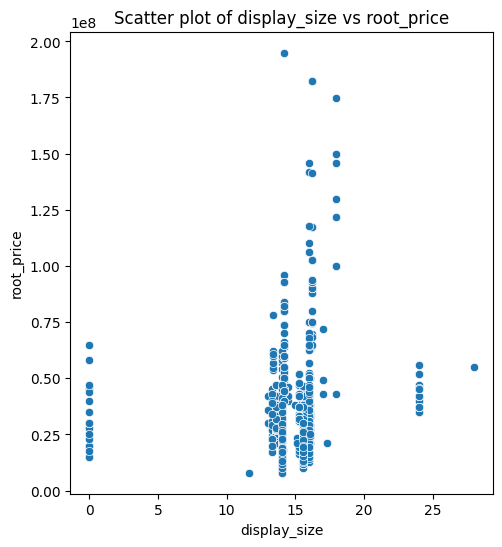

In [17]:
symmetrics = []
skews = [] # transform

numeric_df = df[numerical_cols]
numeric_df.drop('root_price', axis=1, inplace=True)

for column in numeric_df.columns.unique():
    #Có thể trực quan với boxplot để thấy rõ
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[column], y=df['root_price'])
    plt.title(f'Scatter plot of {column} vs root_price')
    skewness = df[column].skew()
    if skewness > -0.5 and skewness < 0.5:
        print(f'{column} tương đối gần mức đối xứng {skewness}')
        symmetrics.append(column)
    elif skewness > 0.5:
        print(f'{column} lệch phải {skewness}')
        skews.append(column)
    else:
        print(f'{column} lệch trái {skewness}')
        skews.append(column)
        
print()
print('-'*10, 'Skew', '-'*10)
print(skews)
print('-'*10, 'Symmetric', '-'*10)
print(symmetrics)

In [18]:
# Tính toán kurtosis cho từng biến
kurtosis_values = numeric_df.kurtosis()

# Xác định ngưỡng để xem biến nào có giá trị kurtosis cao
threshold = 1 

outliers = kurtosis_values[abs(kurtosis_values) > threshold]

print("Các giá trị:")
print(kurtosis_values)

# Hiển thị các biến có giá trị kurtosis cao
print("Các biến có giá trị kurtosis cao:")
print(outliers)

Các giá trị:
height_mm               9.161485
storage_max_support    21.664888
display_width           2.647986
width_mm                9.175195
cpu_max_speed          -0.149647
cpu_threads             3.335470
cpu_cores               4.342736
ram_speed              -1.183601
product_weight          5.663256
cpu_speed              -1.399182
ram_storage            45.925511
battery_capacity        1.368280
depth_mm               21.598373
display_height          0.698790
display_size           12.496183
dtype: float64
Các biến có giá trị kurtosis cao:
height_mm               9.161485
storage_max_support    21.664888
display_width           2.647986
width_mm                9.175195
cpu_threads             3.335470
cpu_cores               4.342736
ram_speed              -1.183601
product_weight          5.663256
cpu_speed              -1.399182
ram_storage            45.925511
battery_capacity        1.368280
depth_mm               21.598373
display_size           12.496183
dtype: float64

Qua tính giá trị thì hầu hết các features đều có phân phôi lệch trái hoặc phải và hình dạng phân phối nhọn

một số cột có phân phối gần chuẩn và không nhọn:

'cpu_max_speed', 'ram_speed', 'cpu_speed', 'display_height' 

In [19]:
print("\n--- Phương pháp Z-score ---")
df_sym = df[symmetrics]

threshold_z = 3 # Ngưỡng Z-score phổ biến

for col in df_sym.columns.unique():
    if pd.api.types.is_numeric_dtype(df_sym[col]): # Chỉ áp dụng cho cột số
        z_scores = np.abs(stats.zscore(df_sym[col].dropna())) # Tính Z-score, dropna để tránh lỗi
        outliers_z = df_sym[col][z_scores > threshold_z] # Lấy các giá trị outlier
        
        print(f"\nOutliers trong cột '{col}' sử dụng Z-score (ngưỡng={threshold_z}):")
        if not outliers_z.empty:
            print(outliers_z.unique())
            # print(f"  Index gốc của outliers: {original_indices_z.tolist()}")
        else:
            print("  Không tìm thấy outlier.")
    else:
        print(f"Cột '{col}' không phải kiểu số, bỏ qua Z-score.")


--- Phương pháp Z-score ---

Outliers trong cột 'cpu_max_speed' sử dụng Z-score (ngưỡng=3):
[2.8 2.6]

Outliers trong cột 'ram_speed' sử dụng Z-score (ngưỡng=3):
  Không tìm thấy outlier.

Outliers trong cột 'cpu_speed' sử dụng Z-score (ngưỡng=3):
  Không tìm thấy outlier.

Outliers trong cột 'display_height' sử dụng Z-score (ngưỡng=3):
[0]


In [20]:
print("\n--- Phương pháp IQR ---")
df_skew = df[skews]
iqr_multiplier = 1.5 # Hệ số nhân IQR (1.5 cho outlier, 3 cho extreme outlier)

for col in df_skew.columns.unique():
    if pd.api.types.is_numeric_dtype(df_skew[col]):
        Q1 = df_skew[col].quantile(0.25)
        Q3 = df_skew[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        outliers_iqr = df_skew[(df_skew[col] < lower_bound) | (df_skew[col] > upper_bound)][col]
        
        print(f"\nOutliers trong cột '{col}' sử dụng IQR (hệ số={iqr_multiplier}):")
        print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"  Giới hạn dưới: {lower_bound:.2f}, Giới hạn trên: {upper_bound:.2f}")
        if not outliers_iqr.empty:
            print(outliers_iqr.unique())
        else:
            print("  Không tìm thấy outlier.")
    else:
        print(f"Cột '{col}' không phải kiểu số, bỏ qua IQR.")


--- Phương pháp IQR ---

Outliers trong cột 'height_mm' sử dụng IQR (hệ số=1.5):
  Q1: 220.42, Q3: 249.50, IQR: 29.08
  Giới hạn dưới: 176.79, Giới hạn trên: 293.13
[307.5 127.   19.7 369.  461.  297.4  23.5 323.7  23.3 298.  307.9 158.7
 300.  312.8 294. ]

Outliers trong cột 'storage_max_support' sử dụng IQR (hệ số=1.5):
  Q1: 512.00, Q3: 1024.00, IQR: 512.00
  Giới hạn dưới: -256.00, Giới hạn trên: 1792.00
[2048 4096 3072 6144 8192]

Outliers trong cột 'display_width' sử dụng IQR (hệ số=1.5):
  Q1: 1920.00, Q3: 2880.00, IQR: 960.00
  Giới hạn dưới: 480.00, Giới hạn trên: 4320.00
[   0 4480]

Outliers trong cột 'width_mm' sử dụng IQR (hệ số=1.5):
  Q1: 312.60, Q3: 359.00, IQR: 46.40
  Giới hạn dưới: 243.00, Giới hạn trên: 428.60
[127.  197.   19.7 547.   35.8  35.7 163.7   1.6]

Outliers trong cột 'cpu_threads' sử dụng IQR (hệ số=1.5):
  Q1: 12.00, Q3: 16.00, IQR: 4.00
  Giới hạn dưới: 6.00, Giới hạn trên: 22.00
[24 28 32  2  4 26]

Outliers trong cột 'cpu_cores' sử dụng IQR (hệ số=

thực hiện tính pearsonr để tính chỉ số tìm features có ảnh hưởng tới biến target root_price để đưa vào bài toán

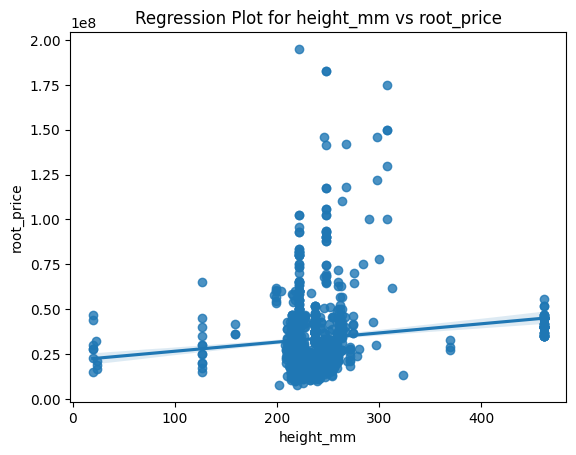


Correlation Coefficient and p-value for height_mm vs root_price:
Correlation Coefficient: 0.1367733118580952
P-value: 6.717206031483858e-06
Không ảnh hưởng


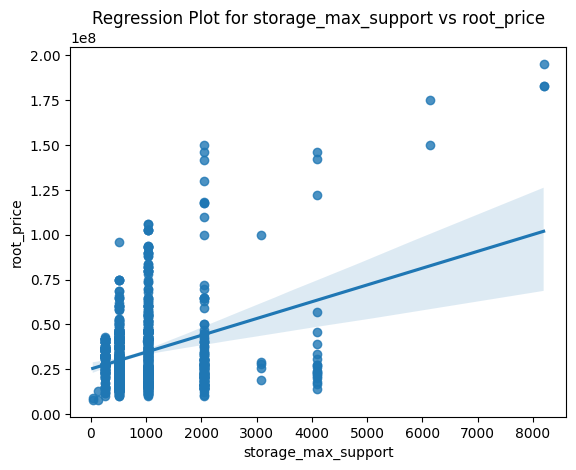


Correlation Coefficient and p-value for storage_max_support vs root_price:
Correlation Coefficient: 0.3559699131408157
P-value: 1.7102897993068496e-33
Có ảnh hưởng


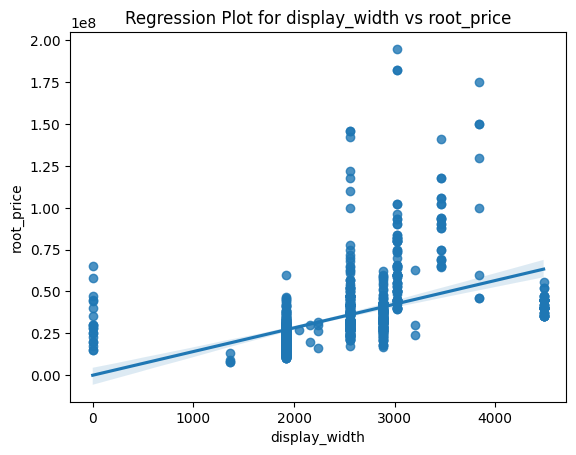


Correlation Coefficient and p-value for display_width vs root_price:
Correlation Coefficient: 0.4791354644929877
P-value: 7.586035337383246e-63
Có ảnh hưởng


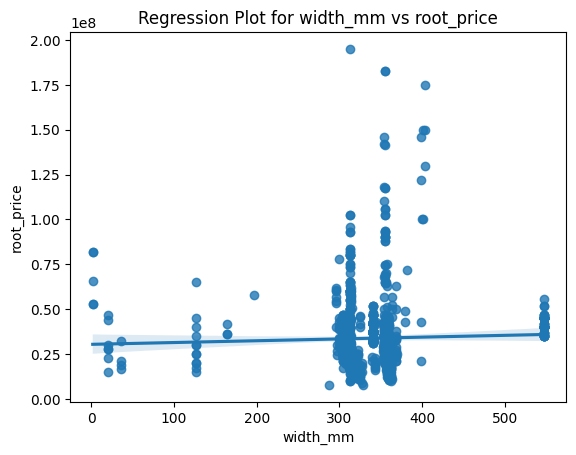


Correlation Coefficient and p-value for width_mm vs root_price:
Correlation Coefficient: 0.03191427154214983
P-value: 0.29560001983741424
Không ảnh hưởng


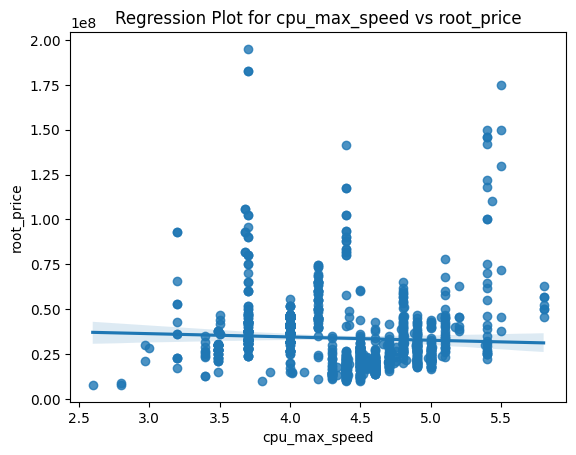


Correlation Coefficient and p-value for cpu_max_speed vs root_price:
Correlation Coefficient: -0.043757378355062694
P-value: 0.15146744093626024
Không ảnh hưởng


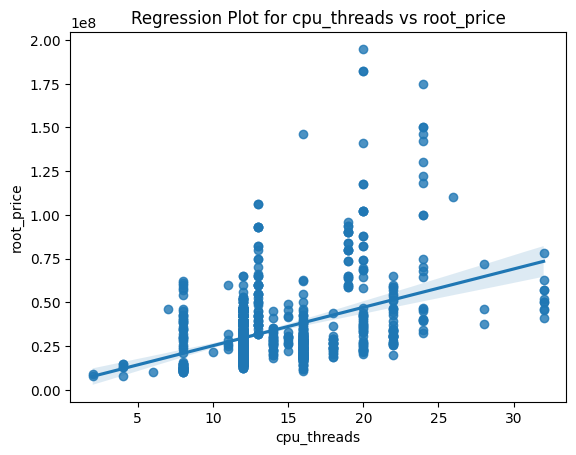


Correlation Coefficient and p-value for cpu_threads vs root_price:
Correlation Coefficient: 0.41249633603905234
P-value: 1.8657238734210288e-45
Có ảnh hưởng


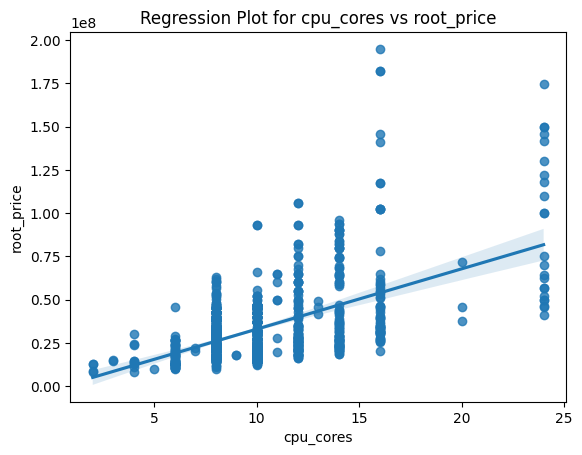


Correlation Coefficient and p-value for cpu_cores vs root_price:
Correlation Coefficient: 0.5406787522022123
P-value: 1.0242352818219854e-82
Có ảnh hưởng


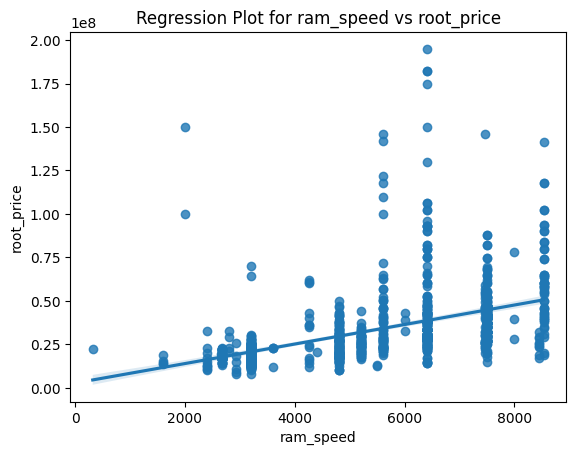


Correlation Coefficient and p-value for ram_speed vs root_price:
Correlation Coefficient: 0.4739197704369771
P-value: 2.424475225538719e-61
Có ảnh hưởng


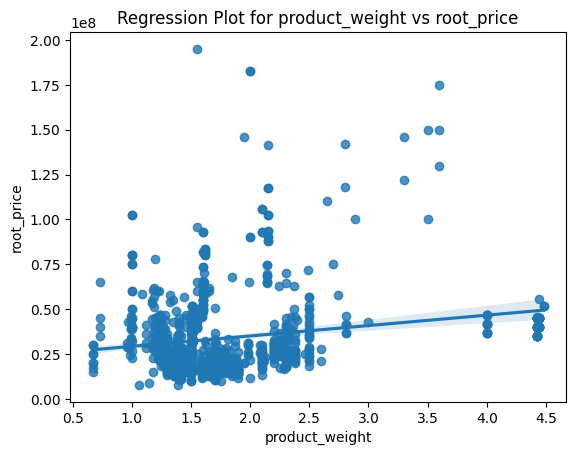


Correlation Coefficient and p-value for product_weight vs root_price:
Correlation Coefficient: 0.1905417800921076
P-value: 2.9614821592997814e-10
Không ảnh hưởng


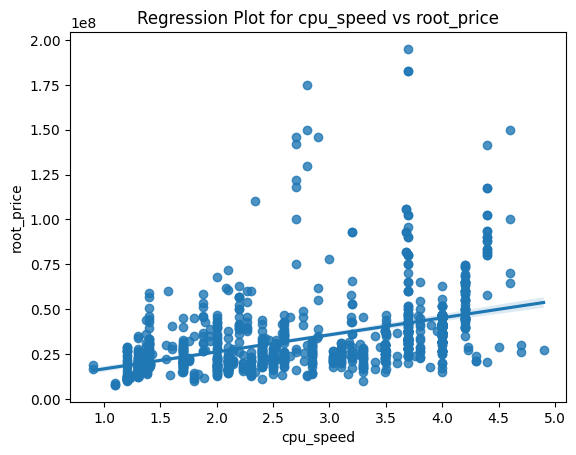


Correlation Coefficient and p-value for cpu_speed vs root_price:
Correlation Coefficient: 0.4509240955394268
P-value: 5.205439218727384e-55
Có ảnh hưởng


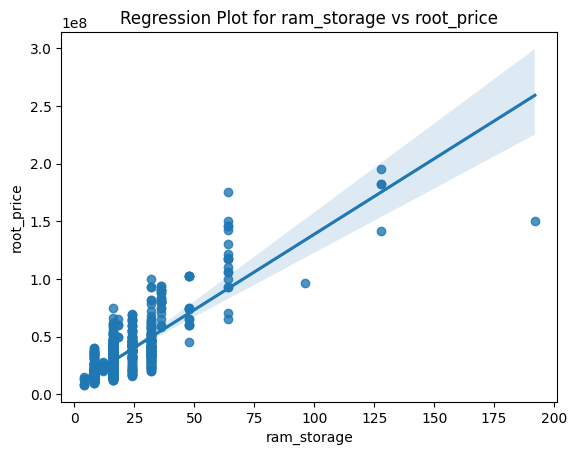


Correlation Coefficient and p-value for ram_storage vs root_price:
Correlation Coefficient: 0.791473874375795
P-value: 7.093519989450327e-232
Có ảnh hưởng


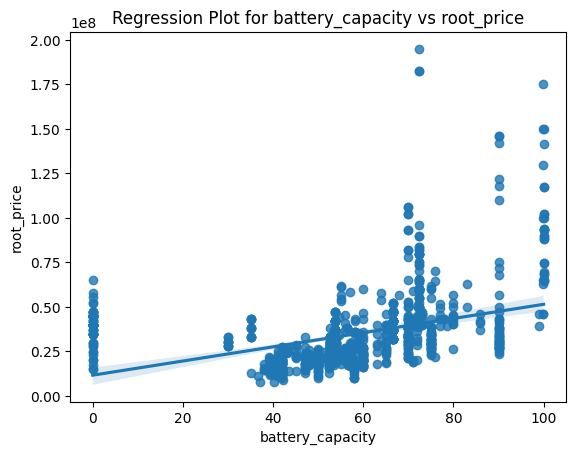


Correlation Coefficient and p-value for battery_capacity vs root_price:
Correlation Coefficient: 0.3879432320269462
P-value: 5.702557048786087e-40
Có ảnh hưởng


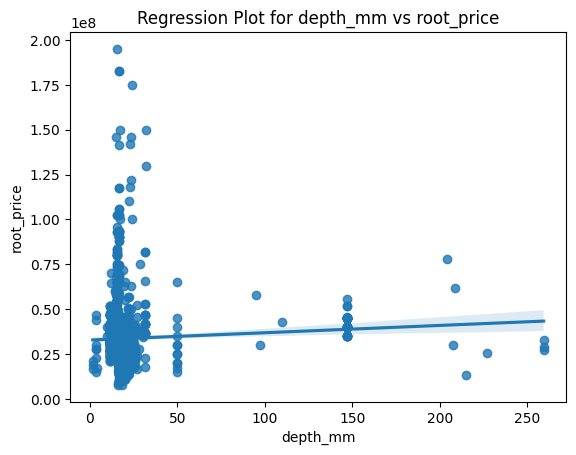


Correlation Coefficient and p-value for depth_mm vs root_price:
Correlation Coefficient: 0.058228881165627994
P-value: 0.056204132510851615
Không ảnh hưởng


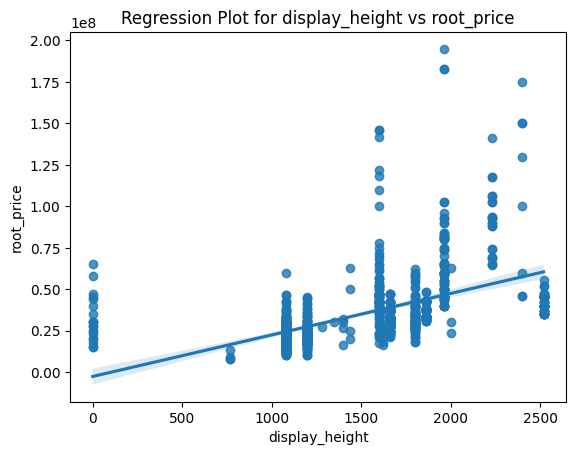


Correlation Coefficient and p-value for display_height vs root_price:
Correlation Coefficient: 0.5398262036598278
P-value: 2.0628384592181294e-82
Có ảnh hưởng


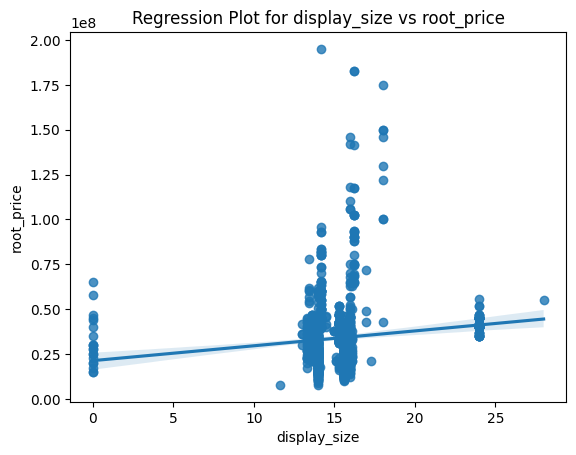


Correlation Coefficient and p-value for display_size vs root_price:
Correlation Coefficient: 0.11561809951860766
P-value: 0.00014417119549669526
Không ảnh hưởng


---------- Impact ----------
['storage_max_support', 'display_width', 'cpu_threads', 'cpu_cores', 'ram_speed', 'cpu_speed', 'ram_storage', 'battery_capacity', 'display_height']
---------- Not Impact ----------
['height_mm', 'width_mm', 'cpu_max_speed', 'product_weight', 'depth_mm', 'display_size']


In [21]:
# abs(coefficient) < 0.3 và p-value < 0.05 sẽ là các feature không ảnh hưởng  
def is_Affected(p_value, p_coef):
  if p_value >= 0.05: return 'Không ảnh hưởng'
  if p_coef >= -0.3 and p_coef <= 0.3:
    return 'Không ảnh hưởng'
  else:
    return 'Có ảnh hưởng'

numeric_df = df[numerical_cols]

# Chọn các biến số kiểu số để xem xét
numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns

num_impact_cols = []
non_impact_cols = []

# Tạo một matrix scatter plot cho từng biến số so với giá xe
for var in numerical_vars:
    if var == 'root_price':
        continue
    sns.regplot(x=var, y='root_price', data=numeric_df)
    plt.title(f'Regression Plot for {var} vs root_price')
    plt.show()

    # Tính hệ số tương quan và p-value bằng stats.pearsonr
    corr_coef, p_value = stats.pearsonr(numeric_df[var], df['root_price'])
    
    print(f'\nCorrelation Coefficient and p-value for {var} vs root_price:')
    print(f'Correlation Coefficient: {corr_coef}')
    print(f'P-value: {p_value}')
    res = is_Affected(p_value, corr_coef)
    print(res)
    if res == 'Có ảnh hưởng': num_impact_cols.append(var)
    else: non_impact_cols.append(var)
    
print('\n')
print('-'*10, 'Impact', '-'*10)
print(num_impact_cols)
print('-'*10, 'Not Impact', '-'*10)
print(non_impact_cols)

danh sách các features có ảnh hưởng và tạo ra tập df_train riêng

In [22]:
use_cols = num_impact_cols + cat_impact_feats + ['root_price']
df_train = df[use_cols]
df_train

,storage_max_support,display_width,cpu_threads,cpu_cores,ram_speed,cpu_speed,ram_storage,battery_capacity,display_height,material,...,vga_brand,vga_vram,laptop_camera,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,do_hoa_ky_thuat,cao_cap_sang_trong,root_price
0,2048,2560,24,12,7500,2.000000,16,73.0,1600,vỏ nhựa - nắp lưng kim loại,...,nvidia,8.0,full hd,other_brand,0,1,0,1,0,39990000
1,1024,1920,16,10,4800,2.400000,16,47.0,1080,vỏ nhựa,...,intel,0.0,hd,intel,1,0,0,1,0,18190000
2,512,1920,8,6,3200,1.200000,8,42.0,1080,vỏ nhựa,...,intel,0.0,hd,intel,1,0,0,1,1,10690000
3,256,2560,12,8,4266,3.200000,8,58.2,1600,vỏ kim loại,...,apple,0.0,hd,apple,1,1,1,1,1,17190000
4,1024,1920,16,12,3200,2.500000,8,57.5,1080,vỏ nhựa,...,nvidia,4.0,hd,intel,0,0,0,1,1,18690000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,512,1920,15,10,5200,2.521667,16,53.5,1080,vỏ nhựa - nắp lưng kim loại,...,nvidia,4.0,hd,intel,0,0,0,1,0,29990000
1072,1024,2560,8,8,4266,2.100000,16,55.0,1600,vỏ kim loại,...,intel,0.0,full hd,intel,1,0,1,0,0,60990000
1073,1024,1920,18,14,7467,1.368290,16,65.0,1200,vỏ kim loại,...,intel,0.0,full hd,intel,1,0,1,0,0,25990000
1074,1024,2880,8,8,8533,2.265349,32,70.0,1800,vỏ kim loại,...,intel,0.0,full hd,intel,1,0,1,0,1,37990000


xem xét độ lệch của các features kiểu số

In [23]:
desc = df_train.describe().T  # Transpose để cột thành hàng
desc['range'] = desc['max'] - desc['min']
desc[['mean', 'std', 'min', 'max', 'range']].sort_values(by='range', ascending=False)

,mean,std,min,max,range
root_price,3.389514e+07,2.166959e+07,7990000.0,194990000.0,187000000.0
ram_speed,5.565454e+03,1.829918e+03,320.0,8533.0,8213.0
storage_max_support,9.253206e+02,8.248606e+02,32.0,8192.0,8160.0
display_width,2.403145e+03,7.334852e+02,0.0,4480.0,4480.0
display_height,1.461532e+03,4.670141e+02,0.0,2520.0,2520.0
ram_storage,2.003532e+01,1.308700e+01,4.0,192.0,188.0
battery_capacity,5.576920e+01,2.111868e+01,0.0,100.0,100.0
cpu_threads,1.395539e+01,4.077375e+00,2.0,32.0,30.0
cpu_cores,1.028346e+01,3.358093e+00,2.0,24.0,22.0
cpu_speed,2.799987e+00,1.031810e+00,0.9,4.9,4.0


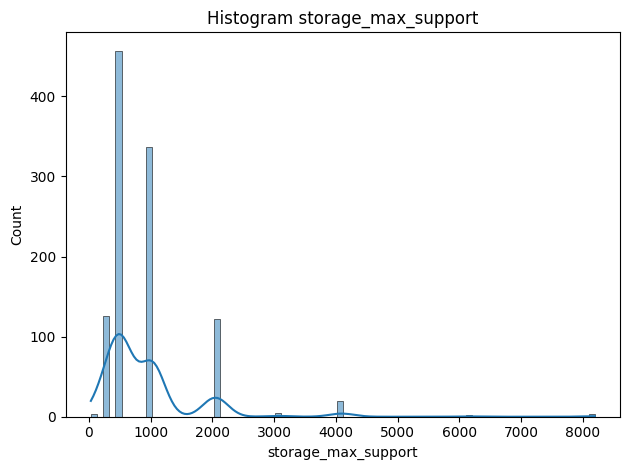

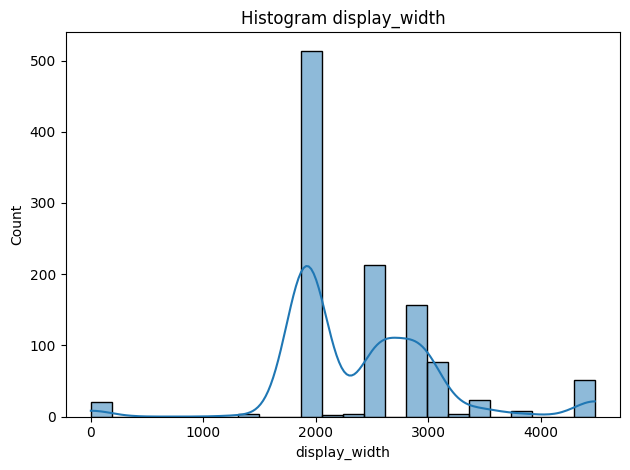

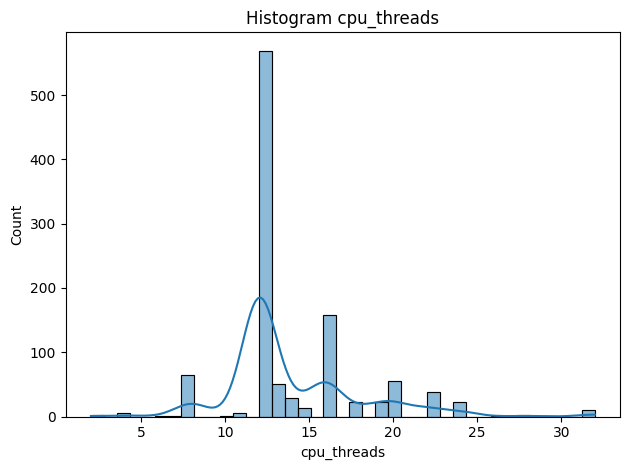

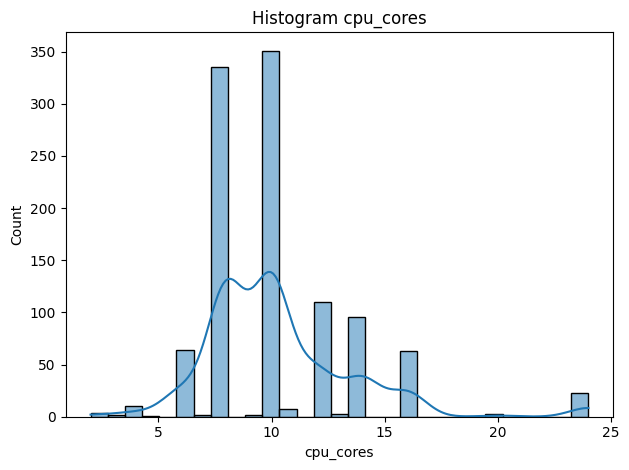

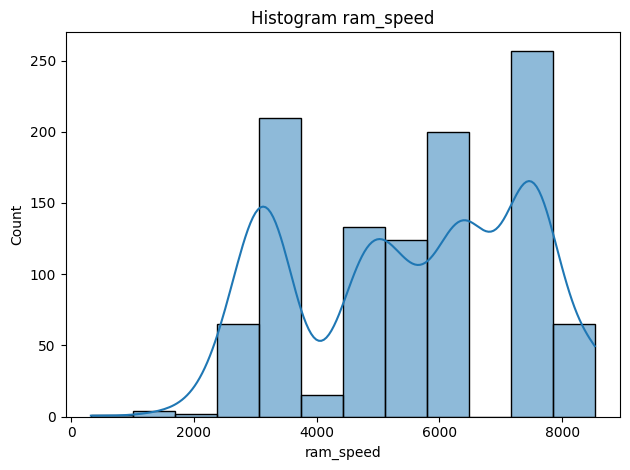

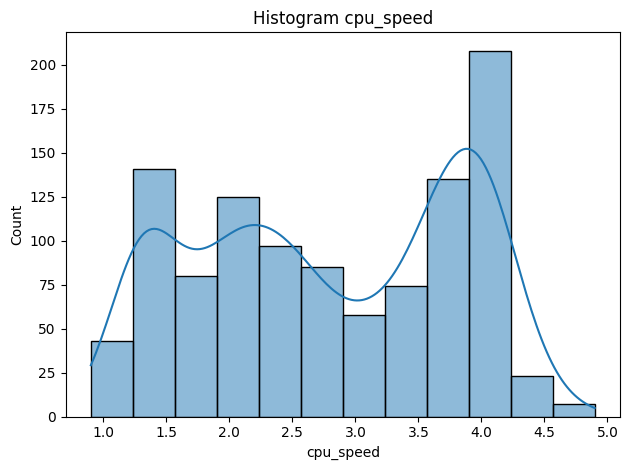

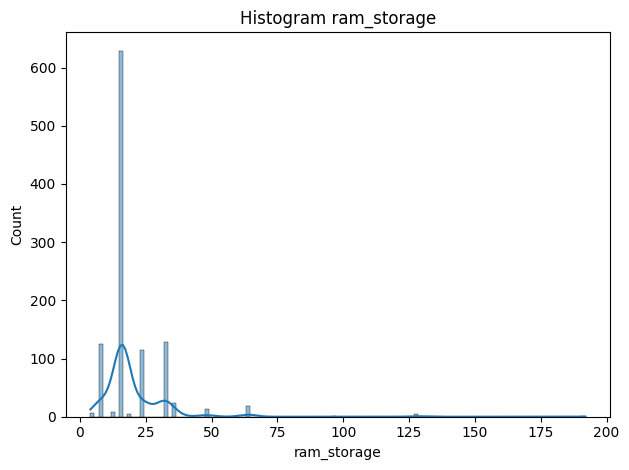

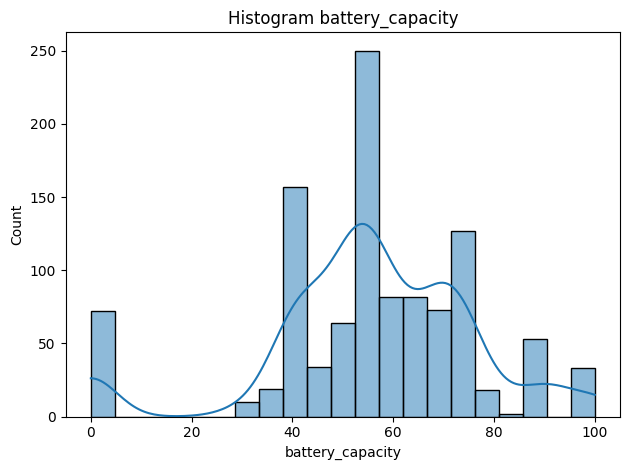

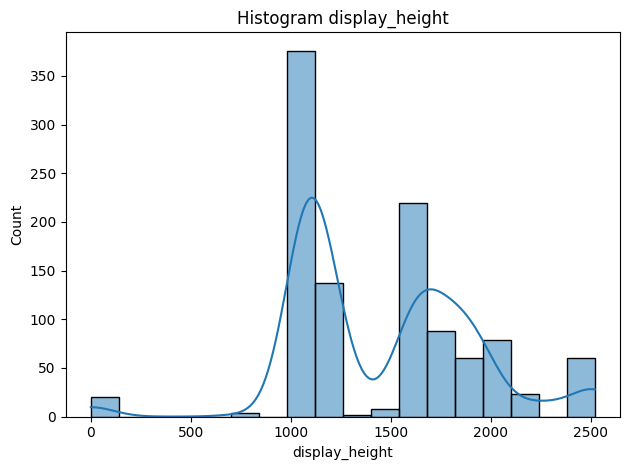

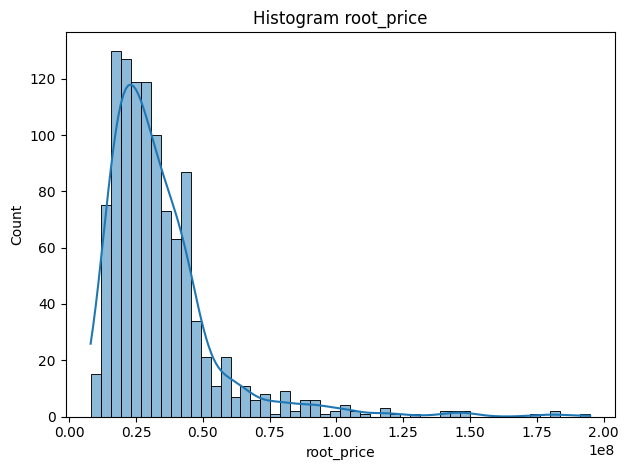

In [24]:
for col in df_train.select_dtypes(include=np.number).columns.unique():
    sns.histplot(data=df_train, x=col, kde=True)
    plt.title(f"Histogram {col}")
    plt.tight_layout()
    plt.show()

các biến số có trọng số lệch -> dùng RobustScaler để chuẩn hóa khi chạy mô hình

## Một số hàm cần thiết

In [25]:
# Hàm tính metrics
def get_metrics(name, model, X_train, Y_train, X_test, Y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    return {
        'Model': name,
        'Train R²': model.score(X_train, Y_train),
        'Test R²': model.score(X_test, Y_test),
        'RMSE': f"{rmse:,.0f}",
        'Cross-Val R²(mean)': cross_val_score(model, X_train, Y_train, cv=5).mean()
    }
    
# Hàm lấy parameters tốt nhất
def get_best_params(tuning_list):
    print("Best parameters:")
    for name, model in tuning_list:
        if hasattr(model, 'best_params_'):
            print(f"{name}:")
            for param, value in model.best_params_.items():
                print(f"   - {param}: {value}")
        else:
            print(f"{name} does not have best_params_")


# Ham truc quan ket qua
def visualize_result(model_list, Y_test): # model_list = [(name_model, model), ...]
    plt.figure(figsize=(18, 5))
    # model_list = [('Linear', pred_linear), ('Random Forest', pred_rf), ('XGBoost', pred_xgb)]
    for i, (label, pred) in enumerate(model_list):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(Y_test, label='Actual', color='red')
        sns.kdeplot(pred, label='Predicted', color='blue')
        plt.title(label)
        plt.legend()

    plt.tight_layout()
    plt.show()

## Tạo train test dataset và pipline xử lý dữ liệu

In [26]:
# Tách features và target
X = df_train.drop('root_price', axis=1)
Y = df_train['root_price']
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['material', 'manufacturer', 'ram_type', 'os_version',
                        'laptop_color', 'vga_brand', 'cpu_brand', 'laptop_camera']

# Chia tập train test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# # Chuẩn hóa Y_train trước khi chạy linear model
# scaler = RobustScaler()
# Y_train_scaled = scaler.fit_transform(Y_train.values.reshape(-1, 1)).ravel()

In [43]:
# Scale biến số bằng RobustScaler()
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Tạo ColumnTransformer để kết hợp các bước tiền xử lý cho từng loại cột
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

preprocessor_linear = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', RobustScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# # xử lý cho tinh chỉnh siêu tham sô mô hình huấn luyện dạng tree-based với các biến phân loại thuộc kiểu nominal -> giảm kích thước do OneHotEncoder gây ra tránh underfit
# preprocessor_tunning = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(), categorical_features)
#     ])

## Training trên df_train: dùng LinearRegression là mô hình baseline và 2 mô hình Tree-based (RandomForest, XGBoost) để thích ứng với outlier tốt hơn

               Model  Train R²   Test R²        RMSE  Cross-Val R²(mean)
0  Linear Regression  0.863529  0.760417  11,559,267            0.839004
1      Random Forest  0.988117  0.915223   6,876,104            0.904023
2            XGBoost  0.981974  0.933820   6,075,269            0.928445


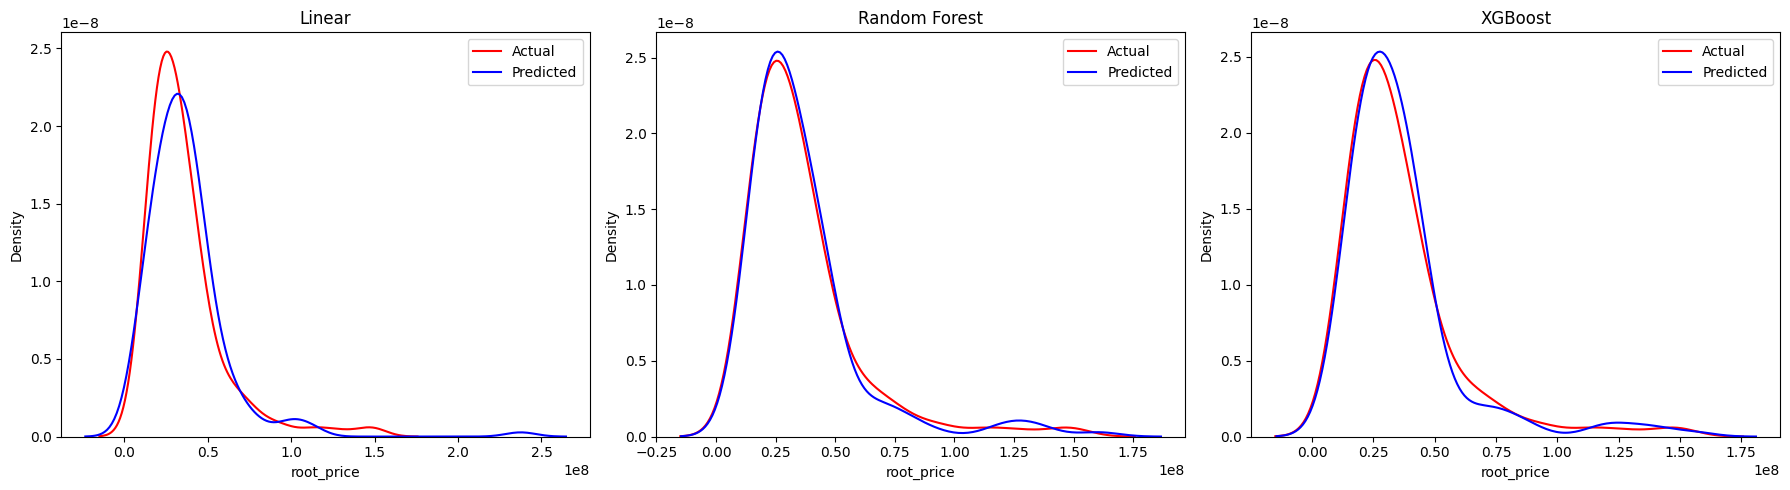

In [28]:
# Linear Regression -> can preprocessing
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Random Forest Regressor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=1))
])

# XGBoost Regressor
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=1))
])

# Fit models
linear_model.fit(X_train, Y_train)
rf_model.fit(X_train, Y_train)
xgb_model.fit(X_train, Y_train)

# Predictions
# y_linear = linear_model.predict(X_test)
# pred_linear = scaler.inverse_transform(y_linear.reshape(-1, 1)).ravel()
pred_linear = linear_model.predict(X_test)
pred_rf = rf_model.predict(X_test)
pred_xgb = xgb_model.predict(X_test)

# Result
linear_res = get_metrics('Linear Regression', linear_model, X_train, Y_train, X_test, Y_test, pred_linear)
rf_res = get_metrics('Random Forest', rf_model, X_train, Y_train, X_test, Y_test, pred_rf)
xgb_res = get_metrics('XGBoost', xgb_model, X_train, Y_train, X_test, Y_test, pred_xgb)

res = [linear_res, rf_res,xgb_res]
res_df = pd.DataFrame(res)
print(res_df)

# Visualize
model_list = [('Linear', pred_linear), ('Random Forest', pred_rf), ('XGBoost', pred_xgb)]
visualize_result(model_list, Y_test)

## Tunning 3 models

### Linear Regression

- Sử dụng PolynomialFeatures để tìm ra bậc tối ưu cho mô hình học
- Sử dụng Lasso và Ridge để thực hiện Feature Selection và giảm thiểu Multicolinearity

### Random Forest
| Tham số             | Ý nghĩa                                                      |
| ------------------- | ------------------------------------------------------------ |
| `n_estimators`      | Số cây → càng nhiều cây, mô hình càng ổn định                |
| `max_depth`         | Độ sâu tối đa của cây → kiểm soát độ phức tạp và overfitting |
| `min_samples_split` | Tối thiểu mẫu để chia node → tăng giảm độ phân nhánh         |
| `min_samples_leaf`  | Tối thiểu mẫu ở node lá → giảm overfitting ở nhánh nhỏ       |
| `max_features`      | Tỷ lệ đặc trưng được chọn ngẫu nhiên tại mỗi split           |

### XGBoost

| Tham số            | Ý nghĩa                                                    |
| ------------------ | ---------------------------------------------------------- |
| `n_estimators`     | Số vòng boosting                                           |
| `max_depth`        | Độ sâu cây → kiểm soát độ phức tạp                         |
| `learning_rate`    | Tốc độ học → nhỏ giúp mô hình ổn định hơn                  |
| `subsample`        | Tỷ lệ mẫu được lấy cho mỗi cây → tăng tính ngẫu nhiên      |
| `colsample_bytree` | Tỷ lệ đặc trưng được lấy cho mỗi cây                       |
| `gamma`            | Độ phức tạp tối thiểu để chia cây tiếp → kiểm soát overfit |
| `reg_alpha`        | Regularization L1 → khử nhiễu                              |
| `reg_lambda`       | Regularization L2 → làm mượt                               |

Fitting models with GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Best parameters:
Linear Regression:
   - poly__degree: 2
   - regressor: Ridge()
   - regressor__alpha: 10.0
Random Forest:
   - regressor__max_depth: 30
   - regressor__max_features: 0.3
   - regressor__min_samples_leaf: 1
   - regressor__min_samples_split: 2
   - regressor__n_estimators: 500
XGBoost:
   - regressor__colsample_bytree: 0.7
   - regressor__gamma: 0
   - regressor__learning_rate: 0.1
   - regressor__max_depth: 3
   - regressor__n_estimators: 800
   - regressor__reg_alpha: 0.1
   - regressor__reg_lambda: 5.0
   - regressor__subsample: 1.0
               Model  Train R²   Test R²       RMSE  Cross-Val R²(mean)
0  Linear Regression  0.973799  0.864662  8,687,841            0.922041
1      Random Forest  0.990319  0.944519  5,562,546            0.92473

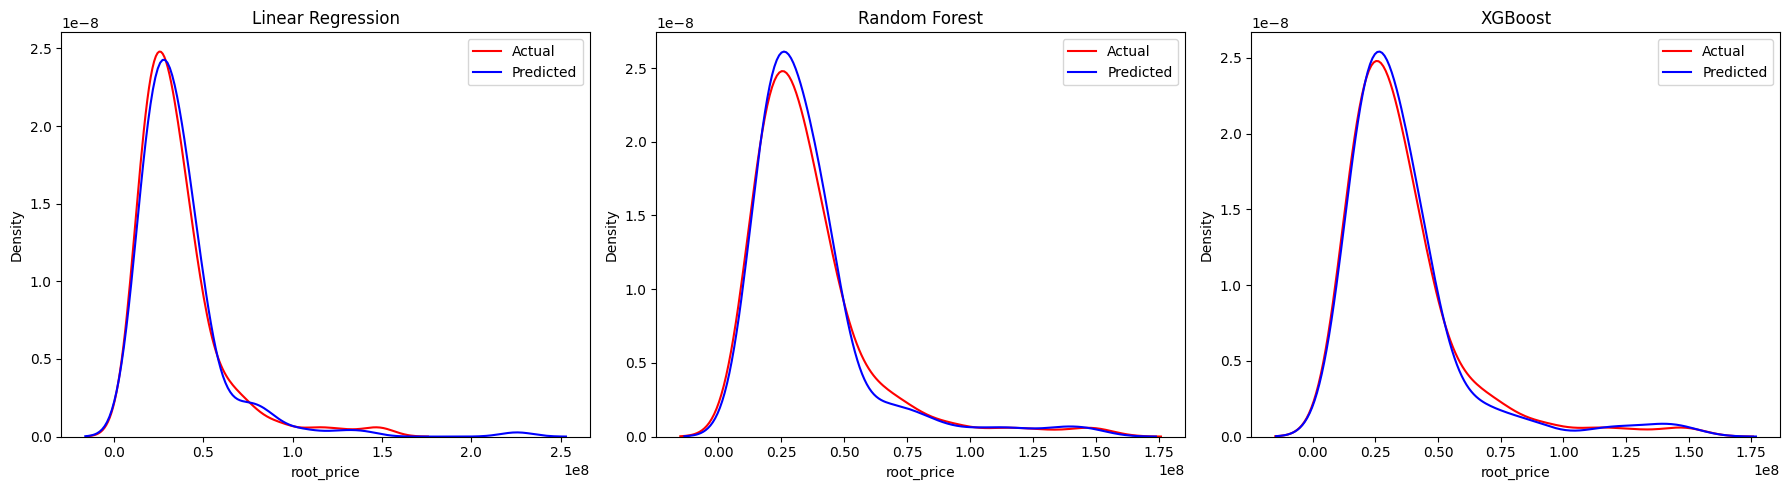

In [41]:
# Linear regression: using Ridge for deadling multicollinearity and Lasso for feature selection
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regressor', LinearRegression())  # Placeholder, sẽ override bằng param_grid
])
lr_params = [
    {
        'poly__degree': [1, 2, 3],
        'regressor': [LinearRegression()]
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    {
        'poly__degree': [1, 2],
        'regressor': [Lasso(max_iter=10000)],
        'regressor__alpha': [0.01, 0.1, 1.0]
    }
]
lr_grid = GridSearchCV(lr_pipeline, lr_params, scoring='r2', cv=5, n_jobs=-1, verbose=1)


# Random Forest: tuning n_estimators và max_depth
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=1))
])
# rf_params = {
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__max_depth': [None, 10, 20, 30],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 4]
# }
rf_params = {
    'regressor__n_estimators': [300, 500, 800],
    'regressor__max_depth': [20, 30, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 0.3, 0.7]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)


# XGBoost: tunning max_depth, n_estimators, learning_rate
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=1, objective='reg:squarederror'))
])
# xgb_params = {
#     'regressor__n_estimators': [100, 200, 500],
#     'regressor__max_depth': [3, 5, 7],
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__subsample': [0.7, 0.8, 1.0],
#     'regressor__colsample_bytree': [0.7, 0.8, 1.0]
# }
xgb_params = {
    'regressor__n_estimators': [200, 500, 800],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.7, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.9, 1.0],
    'regressor__gamma': [0, 1, 5],
    'regressor__reg_alpha': [0, 0.1, 1.0],
    'regressor__reg_lambda': [1.0, 5.0, 10.0]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)


# Fit models
print("Fitting models with GridSearchCV...")

lr_grid.fit(X_train, Y_train)
rf_grid.fit(X_train, Y_train)
xgb_grid.fit(X_train, Y_train)

# Best models
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

# Predictions
pred_linear_tunned = best_lr.predict(X_test)
pred_rf_tunned = best_rf.predict(X_test)
pred_xgb_tunned = best_xgb.predict(X_test)

# Result
tunning_list = [('Linear Regression', lr_grid), ('Random Forest', rf_grid), ('XGBoost', xgb_grid)]

get_best_params(tunning_list)

linear_res_tunned = get_metrics('Linear Regression', best_lr, X_train, Y_train, X_test, Y_test, pred_linear_tunned)
rf_res_tunned = get_metrics('Random Forest', best_rf, X_train, Y_train, X_test, Y_test, pred_rf_tunned)
xgb_res_tunned = get_metrics('XGBoost', best_xgb, X_train, Y_train, X_test, Y_test, pred_xgb_tunned)

res_tunned = [linear_res_tunned, rf_res_tunned,xgb_res_tunned]
res_tunned_df = pd.DataFrame(res_tunned)
print(res_tunned_df)

# Visualize
model_list = [('Linear Regression', pred_linear_tunned), ('Random Forest', pred_rf_tunned), ('XGBoost', pred_xgb_tunned)]
visualize_result(model_list, Y_test)

## Training tách biệt 2 bộ data (non-outlier, outlier): dùng thuật toán train riêng trên 2 bộ và chọn ra thuật toán kết quả tốt nhất, tạo thành 1 class model ứng dụng 2 mô hình riêng cho 2 trường hợp

In [31]:
# Tìm outlier theo IQR và Z-score, tách thành 2 dataframe
def split_outliers(df, iqr_multiplier=1.5, threshold_z=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skew_values = df[numeric_cols].skew()

    skews = skew_values[abs(skew_values) > 0.5].index.tolist()
    symmetrics = skew_values[abs(skew_values) <= 0.5].index.tolist()
    
    df_skew = df[skews]
    df_sym = df[symmetrics]

    outlier_indices = set()

    # --- IQR ---
    for col in df_skew.columns.unique():
        if pd.api.types.is_numeric_dtype(df_skew[col]):
            Q1 = df_skew[col].quantile(0.25)
            Q3 = df_skew[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR

            outlier_idx_iqr = df_skew[(df_skew[col] < lower_bound) | (df_skew[col] > upper_bound)].index
            outlier_indices.update(outlier_idx_iqr)

    # --- Z-score ---
    for col in df_sym.columns.unique():
        if pd.api.types.is_numeric_dtype(df_sym[col]):
            z_scores = np.abs(stats.zscore(df_sym[col].dropna()))
            outlier_idx_z = df_sym[col].dropna()[z_scores > threshold_z].index
            outlier_indices.update(outlier_idx_z)

    # Tách thành hai DataFrame
    df_outliers = df.loc[list(outlier_indices)].copy()
    df_no_outliers = df.drop(index=outlier_indices).copy()

    return df_outliers, df_no_outliers

df_outliers, df_no_outliers = split_outliers(df_train)

In [32]:
# Chia X, y
X_clean = df_no_outliers.drop(columns='root_price')
y_clean = df_no_outliers['root_price']
# Chia tập train test
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X_clean, y_clean, test_size=0.15, random_state=42)

X_outlier = df_outliers.drop(columns='root_price')
y_outlier = df_outliers['root_price']
# Chia tập train test
X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_outlier, y_outlier, test_size=0.15, random_state=42)

               Model  Train R²   Test R²       RMSE  Cross-Val R²(mean)
0  Linear Regression  0.860117  0.778425  5,707,576            0.807923
1      Random Forest  0.991808  0.932988  8,469,457            0.911677
2            XGBoost  0.996188  0.960013  6,542,414            0.929455


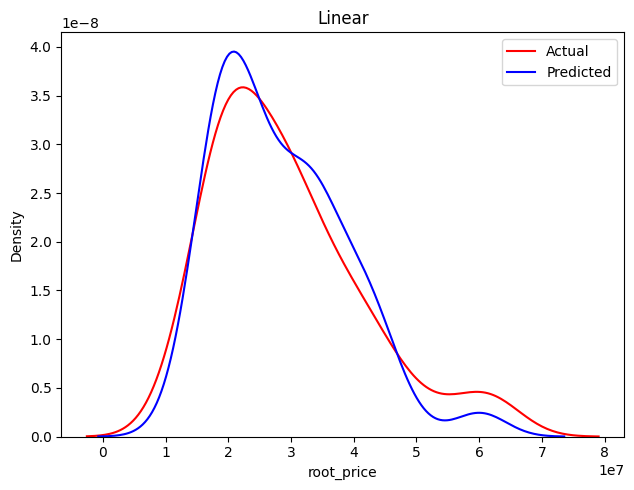

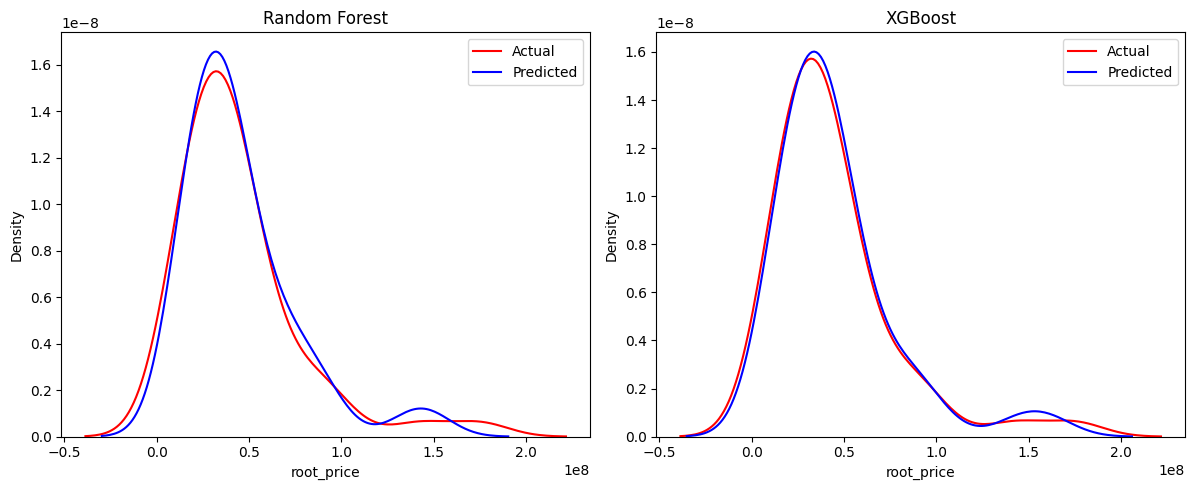

In [ ]:
# Pipeline cho dữ liệu chuẩn
linear_model_cb = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', Ridge(alpha=10.0))
])
# fit
linear_model_cb.fit(X_train_clean, Y_train_clean)

# Pipeline cho outlier (dùng mô hình không nhạy cảm với outlier)
rf_model_cb = Pipeline([
    ('preprocessor', preprocessor),  # chỉ encode, không cần scaler
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=1))
])

xgb_model_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=1))
])
# fit
rf_model_cb.fit(X_train_outlier, Y_train_outlier)
xgb_model_cb.fit(X_train_outlier, Y_train_outlier)

# Predictions
pred_linear_cb = linear_model_cb.predict(X_test_clean)
pred_rf_cb = rf_model_cb.predict(X_test_outlier)
pred_xgb_cb = xgb_model_cb.predict(X_test_outlier)

# Result
linear_res_cb = get_metrics('Linear Regression', linear_model_cb, X_train_clean, Y_train_clean, X_test_clean, Y_test_clean, pred_linear_cb)
rf_res_cb = get_metrics('Random Forest', rf_model_cb, X_train_outlier, Y_train_outlier, X_test_outlier, Y_test_outlier, pred_rf_cb)
xgb_res_cb = get_metrics('XGBoost', xgb_model_cb, X_train_outlier, Y_train_outlier, X_test_outlier, Y_test_outlier, pred_xgb_cb)

res_cb = [linear_res_cb, rf_res_cb,xgb_res_cb]
res_cb_df = pd.DataFrame(res_cb)
print(res_cb_df)

# Visualize
model_list1 = [('Linear', pred_linear_cb)]
model_list2 = [('Random Forest', pred_rf_cb), ('XGBoost', pred_xgb_cb)]
visualize_result(model_list1, Y_test_clean)
visualize_result(model_list2, Y_test_outlier)

Sau khi training 2 bộ riêng biệt, dựa trên kết quả sử dụng 2 mô hình là Linear Regression và XGBoost làm mô hình kết hợp để xử lý 2 trường hợp

In [44]:
# Tạo class là model kết hợp để xử lý trường hợp có outlier
class OutlierAwareRegressor:
    def __init__(self, model_clean, model_outlier, iqr_multiplier=1.5):
        self.model_clean = model_clean
        self.model_outlier = model_outlier
        self.iqr_multiplier = iqr_multiplier
        self.thresholds = None

    def compute_outlier_thresholds(self, df):
        numeric_cols = df.select_dtypes(include='number').columns
        thresholds = {}
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            thresholds[col] = (Q1 - self.iqr_multiplier * IQR, Q3 + self.iqr_multiplier * IQR)
        return thresholds

    def is_outlier_row(self, row):
        for col, (low, high) in self.thresholds.items():
            val = row[col]
            if val < low or val > high:
                return True
        return False

    def fit(self, X, y):
        self.thresholds = self.compute_outlier_thresholds(X)
        is_outlier = X.apply(lambda row: self.is_outlier_row(row), axis=1)

        X_clean, y_clean = X[~is_outlier], y[~is_outlier]
        X_out, y_out = X[is_outlier], y[is_outlier]

        self.model_clean.fit(X_clean, y_clean)
        self.model_outlier.fit(X_out, y_out)

    def predict(self, X):
        preds = []
        for _, row in X.iterrows():
            model = self.model_outlier if self.is_outlier_row(row) else self.model_clean
            pred = model.predict(pd.DataFrame([row]))[0]
            preds.append(pred)
        return np.array(preds)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)
    
    def cross_val_score(self, X, y, n_splits=5):
        r2_scores = []
        rmse_scores = []
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, test_idx in kf.split(X):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            is_outlier = X_tr.apply(lambda row: self.is_outlier_row(row), axis=1)
            X_tr_clean, y_tr_clean = X_tr[~is_outlier], y_tr[~is_outlier]
            X_tr_out, y_tr_out = X_tr[is_outlier], y_tr[is_outlier]

            self.model_clean.fit(X_tr_clean, y_tr_clean)
            self.model_outlier.fit(X_tr_out, y_tr_out)

            y_pred = []
            for _, row in X_te.iterrows():
                model = self.model_outlier if self.is_outlier_row(row) else self.model_clean
                pred = model.predict(pd.DataFrame([row]))[0]
                y_pred.append(pred)

            r2_scores.append(r2_score(y_te, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_te, y_pred)))

        return np.mean(r2_scores), np.mean(rmse_scores)
    
    def get_metrics(self, X_train, Y_train, X_test, Y_test):
        r2_score, rmse = self.cross_val_score(X_train, Y_train)
        return {
            'Train R²': self.score(X_train, Y_train),
            'Test R²': self.score(X_test, Y_test),
            'RMSE': f"{rmse:,.0f}",
            'Cross-Val R²(mean)': r2_score
        }

    def visualize_result(self, label, X_test, Y_test):
        y_pred = self.predict(X_test)
        plt.figure(figsize=(6, 5))
        sns.kdeplot(Y_test, label='Actual', color='red')
        sns.kdeplot(y_pred, label='Predicted', color='blue')
        plt.title(label)
        plt.legend()
        plt.tight_layout()
        plt.show()

   Train R²   Test R²       RMSE  Cross-Val R²(mean)
0  0.947027  0.885263  6,120,777            0.914088


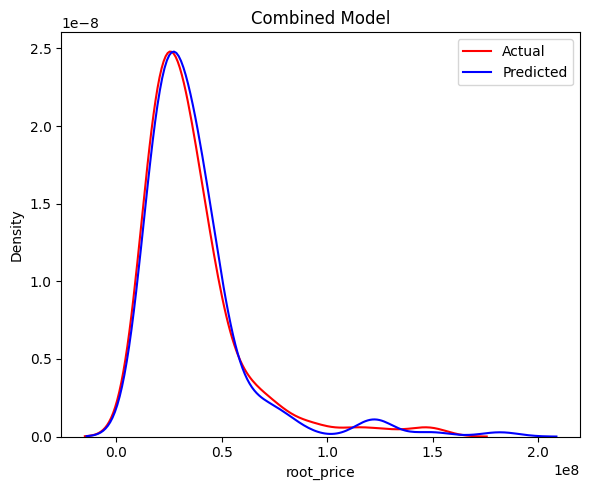

In [45]:
# Instantiate the combined model
combined_model = OutlierAwareRegressor(
    model_clean=linear_model_cb,
    model_outlier=xgb_model_cb
)

# Fit on the full training set
combined_model.fit(X_train, Y_train)

# Predict and evaluate
metrics = combined_model.get_metrics(X_train, Y_train, X_test, Y_test)
metric_df = pd.DataFrame([metrics])
print(metric_df)

# Visualize
combined_model.visualize_result("Combined Model",X_test, Y_test)

## Lưu mô hình tốt nhất

In [46]:
# Lưu model tốt nhất
filename = "xgboost_model.pkl"
joblib.dump(best_xgb, filename)
print(f"Saved best model!")

Saved best model!
